# YOLO-based v-CLR (VOC → UVO) – Partial Fine-tuning

This notebook implements a ConvNeXt-based v-CLR training pipeline with:

- Precomputed `train_items` (no COCO object inside the Dataset) so DataLoader workers work on Windows.
- Random selection of depth vs. stylized view per step (always with the natural view).
- Mixed precision (AMP) for faster GPU training and lower memory.
- YOLOv11s seg model partially fine-tuned (last few stages unfrozen).


In [1]:
import os
import json
import math
import random
from pathlib import Path
from typing import List, Dict, Any, Optional, Tuple
from collections import defaultdict

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import torchvision
from torchvision import transforms as T
from torchvision.ops import box_iou, generalized_box_iou
from torchvision.models import convnext_tiny

from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval
from PIL import Image

# Speed/predictability settings
torch.backends.cudnn.benchmark = True
torch.set_float32_matmul_precision("high")

SEED = 42
random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

if not torch.cuda.is_available():
    raise RuntimeError("CUDA is not available – this notebook expects a GPU.")
device = torch.device("cuda")
print("Using device:", device, torch.cuda.get_device_name(0))


Using device: cuda NVIDIA GeForce RTX 4080


In [2]:
# === Configuration ===

DATA_ROOT = Path(r"C:\workspace\vclr\datasets")

COCO_ROOT = DATA_ROOT
COCO_TRAIN_JSON = COCO_ROOT / "annotations" / "instances_train2017.json"
COCO_VAL_JSON   = COCO_ROOT / "annotations" / "instances_val2017.json"

COCO_TRAIN_IMG_DIR = COCO_ROOT / "train2017"
COCO_VAL_IMG_DIR   = COCO_ROOT / "val2017"

# Extra views
DEPTH_TRAIN_DIR = DATA_ROOT / "train2017_depth_cmap"    # depth as .png
STYLE_TRAIN_DIR = DATA_ROOT / "style_coco_train2017"    # stylized view (if available)
EDGE_TRAIN_DIR  = None                                  # optional

# Non-VOC val + CutLER proposals
NONVOC_VAL_JSON       = DATA_ROOT / "uvo_nonvoc_val_rle.json"
CUTLER_PROPOSALS_JSON = DATA_ROOT / "vCLR_coco_train2017_top5.json"

NONVOC_IMG_DIR = DATA_ROOT / "uvo_videos_dense_frames"

# Training / eval hyperparameters
NUM_EPOCHS         = 4
BASE_LR            = 1e-4
TRAIN_BATCH_SIZE   = 5
VAL_BATCH_SIZE     = 5
TRAIN_NUM_WORKERS  = 0   # safe after we remove COCO from Dataset
VAL_NUM_WORKERS    = 0   # simpler eval
IMG_SIZE           = 800

# v-CLR loss weights
LAMBDA_GT    = 1.0
LAMBDA_OBJ   = 1.0
LAMBDA_SIM   = 1.0
LAMBDA_MATCH = 1.0

# MaskDINO/DINO-style detection and segmentation loss weights (from official configs)
# CLASS_WEIGHT, BOX_WEIGHT, GIOU_WEIGHT, MASK_WEIGHT, DICE_WEIGHT, NO_OBJECT_WEIGHT
LOSS_CLASS_WEIGHT      = 4.0   # classification term
LOSS_BOX_WEIGHT        = 5.0   # box L1 term
LOSS_GIOU_WEIGHT       = 2.0   # (G)IoU term
LOSS_MASK_BCE_WEIGHT   = 5.0   # mask BCE/focal term
LOSS_MASK_DICE_WEIGHT  = 5.0   # mask dice term
LOSS_NO_OBJECT_WEIGHT  = 0.1   # weight for "no object" queries

# Number of object queries per image (DETR / MaskDINO style)
NUM_QUERIES = 300

# VOC 20 classes in COCO naming
VOC_CLASS_NAMES = [
    "person", "bicycle", "car", "motorcycle", "airplane", "bus",
    "train", "truck", "boat",
    "bird", "cat", "dog", "horse", "sheep", "cow",
    "elephant", "bear", "zebra", "giraffe",
    "tv"
]


In [3]:
# === COCO setup & VOC / Non-VOC split ===

coco_train = COCO(str(COCO_TRAIN_JSON))

name_to_id = {cat["name"]: cat["id"] for cat in coco_train.cats.values()}

voc_cat_ids = []
for name in VOC_CLASS_NAMES:
    if name not in name_to_id:
        raise ValueError(f"VOC class '{name}' not found in COCO categories.")
    voc_cat_ids.append(name_to_id[name])

voc_cat_ids = sorted(set(voc_cat_ids))
all_cat_ids = sorted(coco_train.cats.keys())
nonvoc_cat_ids = [cid for cid in all_cat_ids if cid not in voc_cat_ids]

print("VOC category ids:", voc_cat_ids)
print("Non-VOC category ids ({} total):".format(len(nonvoc_cat_ids)),
      nonvoc_cat_ids[:10], "...")


loading annotations into memory...
Done (t=6.07s)
creating index...
index created!
VOC category ids: [1, 2, 3, 4, 5, 6, 7, 8, 9, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 72]
Non-VOC category ids (60 total): [10, 11, 13, 14, 15, 27, 28, 31, 32, 33] ...


In [4]:
# === Load CutLER proposals (COCO xywh -> xyxy for IoU/L1 with detector) ===

with open(CUTLER_PROPOSALS_JSON, "r") as f:
    cutler_data = json.load(f)

proposal_dict: Dict[int, List[Dict[str, torch.Tensor]]] = {}

def _xywh_to_xyxy(boxes_xywh: torch.Tensor) -> torch.Tensor:
    """Convert [x, y, w, h] -> [x1, y1, x2, y2] in the same coordinate system."""
    if boxes_xywh.ndim == 1:
        boxes_xywh = boxes_xywh.unsqueeze(0)
    boxes_xyxy = boxes_xywh.clone()
    boxes_xyxy[:, 2] = boxes_xywh[:, 0] + boxes_xywh[:, 2]  # x2 = x + w
    boxes_xyxy[:, 3] = boxes_xywh[:, 1] + boxes_xywh[:, 3]  # y2 = y + h
    return boxes_xyxy

if isinstance(cutler_data, dict) and "annotations" in cutler_data and "images" in cutler_data:
    # Standard COCO-style proposals: each annotation has bbox=[x,y,w,h] in original pixels
    boxes_by_image = defaultdict(list)
    scores_by_image = defaultdict(list)

    for ann in cutler_data["annotations"]:
        img_id = int(ann["image_id"])
        boxes_by_image[img_id].append(ann["bbox"])               # COCO xywh
        scores_by_image[img_id].append(ann.get("score", 1.0))

    for img_id, boxes_list in boxes_by_image.items():
        boxes_xywh = torch.tensor(boxes_list, dtype=torch.float32)
        boxes_xyxy = _xywh_to_xyxy(boxes_xywh)
        scores = torch.tensor(scores_by_image[img_id], dtype=torch.float32)
        proposal_dict[img_id] = [{"boxes": boxes_xyxy, "scores": scores}]

    print(f"Loaded CutLER-style proposals (COCO JSON) for {len(proposal_dict)} training images.")

elif isinstance(cutler_data, dict):
    # Fallback: dictionary keyed directly by image_id (as string) -> boxes / {boxes,scores}
    skipped_meta_keys: List[str] = []
    for k, v in cutler_data.items():
        try:
            img_id = int(k)
        except ValueError:
            skipped_meta_keys.append(k)
            continue

        if isinstance(v, dict) and "boxes" in v:
            boxes_xywh = torch.tensor(v["boxes"], dtype=torch.float32)
            scores = torch.tensor(
                v.get("scores", [1.0] * len(boxes_xywh)),
                dtype=torch.float32,
            )
        else:
            boxes_xywh = torch.tensor(v, dtype=torch.float32)
            scores = torch.ones(len(boxes_xywh), dtype=torch.float32)

        boxes_xyxy = _xywh_to_xyxy(boxes_xywh)
        proposal_dict[img_id] = [{"boxes": boxes_xyxy, "scores": scores}]

    print("Loaded dict-style proposals for", len(proposal_dict), "training images")
    if skipped_meta_keys:
        print("Skipped non-image keys:", skipped_meta_keys)
else:
    raise ValueError("Unrecognized CUTLER_PROPOSALS_JSON format for proposals.")

# Small sanity check: print one entry (id and shapes)
_example_key = next(iter(proposal_dict.keys()))
_example_entry = proposal_dict[_example_key][0]
print(
    f"Example proposals for image_id={_example_key}: "
    f"boxes={_example_entry['boxes'].shape}, scores={_example_entry['scores'].shape}"
)


Loaded CutLER-style proposals (COCO JSON) for 118287 training images.
Example proposals for image_id=558840: boxes=torch.Size([16, 4]), scores=torch.Size([16])


In [5]:
# === Precompute train_items for a Windows-safe Dataset ===

train_items: List[Dict[str, Any]] = []

for img_id in coco_train.getImgIds():
    img_info = coco_train.loadImgs([img_id])[0]
    ann_ids = coco_train.getAnnIds(imgIds=[img_id], iscrowd=None)
    anns = coco_train.loadAnns(ann_ids)

    boxes = []
    iscrowd = []
    segs = []

    for a in anns:
        if a["category_id"] not in voc_cat_ids:
            continue
        if "bbox" not in a:
            continue
        boxes.append(a["bbox"])              # [x, y, w, h]
        iscrowd.append(a.get("iscrowd", 0))
        segs.append(a.get("segmentation", None))

    item = {
        "image_id": img_id,
        "file_name": img_info["file_name"],
        "boxes": boxes,
        "iscrowd": iscrowd,
        "masks": segs,
        "orig_size": [img_info["height"], img_info["width"]],  # [H, W]
    }
    train_items.append(item)

print("len(train_items) =", len(train_items))


len(train_items) = 118287


In [6]:
%%writefile vclr_dataset3.py
from pathlib import Path
from typing import Any, Dict, List, Optional

import numpy as np
import torch
from torch.utils.data import Dataset
import copy
from PIL import Image
import pycocotools.mask as mask_utils


class VCLRTrainSubset(Dataset):
    """
    Windows-safe v-CLR training subset.

    Each entry in `items` is a Python dict:
      - image_id: int
      - file_name: str
      - boxes: List[List[float]] in xywh (original pixels)
      - iscrowd: List[int]
      - masks: List[segmentation] (COCO polygons or RLE)
      - orig_size: [H, W]

    `proposals` is:
      image_id -> list of { "boxes": Tensor[K,4] (xywh), "scores": Tensor[K] }.
    """

    def __init__(
        self,
        items: List[Dict[str, Any]],
        img_dir: Path,
        depth_dir: Optional[str] = None,
        stylized_dir: Optional[str] = None,
        edge_dir: Optional[str] = None,
        proposals: Optional[Dict[int, List[Dict[str, torch.Tensor]]]] = None,
        transform: Optional[Any] = None,
    ):
        self.items = items
        self.img_dir = Path(img_dir)
        self.depth_dir = Path(depth_dir) if depth_dir is not None else None
        self.stylized_dir = Path(stylized_dir) if stylized_dir is not None else None
        self.edge_dir = Path(edge_dir) if edge_dir is not None else None
        self.proposals = proposals or {}
        self.transform = transform

    def __len__(self) -> int:
        return len(self.items)

    def _load_optional_view(self, root: Optional[Path], file_name: str) -> Optional[Image.Image]:
        if root is None:
            return None
        path = root / file_name
        if not path.is_file():
            alt = None
            if path.suffix.lower() == ".png":
                alt = path.with_suffix(".jpg")
            elif path.suffix.lower() == ".jpg":
                alt = path.with_suffix(".png")
            if alt is None or not alt.is_file():
                return None
            path = alt
        return Image.open(path).convert("RGB")

    def _decode_masks(self, segs, h: int, w: int) -> torch.Tensor:
        if not segs:
            # Legit: there are no masks for this image
            return torch.zeros((0, h, w), dtype=torch.uint8)

        decoded = []
        failed = 0

        for s in segs:
            if s is None:
                failed += 1
                continue

            rle = None
            if isinstance(s, list):
                rles = mask_utils.frPyObjects(s, h, w)
                rle = mask_utils.merge(rles) if isinstance(rles, list) else rles

            elif isinstance(s, dict) and "counts" in s:
                if isinstance(s["counts"], list):
                    rle = mask_utils.frPyObjects(s, h, w)
                    if isinstance(rle, list):
                        rle = mask_utils.merge(rle)
                else:
                    rle = s

            if rle is None:
                failed += 1
                continue

            m = mask_utils.decode(rle).astype("uint8")
            decoded.append(m)

        if not decoded:
            # segs was non-empty but we failed to decode all of them
            # --> better to raise or log, not silently pretend it's background
            raise RuntimeError(
                f"Failed to decode any masks for image; got {len(segs)} seg entries, all invalid."
            )

        return torch.from_numpy(np.stack(decoded, axis=0))




    def __getitem__(self, idx: int) -> Dict[str, Any]:
        item = self.items[idx]
        img_id = int(item["image_id"])
        file_name = item["file_name"]

        # Natural image
        path = self.img_dir / file_name
        if not path.is_file():
            alt = None
            if path.suffix.lower() == ".png":
                alt = path.with_suffix(".jpg")
            elif path.suffix.lower() == ".jpg":
                alt = path.with_suffix(".png")
            if alt is None or not alt.is_file():
                raise FileNotFoundError(f"Image not found: {path} (alt={alt})")
            path = alt
        image_nat = Image.open(path).convert("RGB")

        h0, w0 = item["orig_size"][0], item["orig_size"][1]

        # Extra views
        image_depth = self._load_optional_view(self.depth_dir, file_name)
        image_style = self._load_optional_view(self.stylized_dir, file_name)
        image_edge  = self._load_optional_view(self.edge_dir, file_name)

        # Ground-truth boxes (still in original image coords here)
        boxes = torch.as_tensor(item.get("boxes", []), dtype=torch.float32)
        if boxes.numel() == 0:
            boxes = boxes.reshape(0, 4)

        iscrowd = torch.as_tensor(item.get("iscrowd", []), dtype=torch.int64)
        if iscrowd.numel() == 0:
            iscrowd = iscrowd.reshape(0)

        segs = item.get("masks", [])
        masks = self._decode_masks(segs, h0, w0)  # (N, H0, W0)
        if masks.shape[0] != boxes.shape[0]:
            masks = torch.zeros((boxes.shape[0], h0, w0), dtype=torch.uint8)

        # Class-agnostic: all foreground
        labels = torch.ones((boxes.shape[0],), dtype=torch.int64)

        target: Dict[str, Any] = {
            "boxes": boxes,
            "labels": labels,
            "iscrowd": iscrowd,
            "masks": masks,
            "image_id": torch.tensor([img_id]),
            "orig_size": torch.tensor([h0, w0], dtype=torch.float32),
        }

        # 🔧 FIX: deep-copy proposals so transforms cannot mutate self.proposals
        props_raw = self.proposals.get(img_id, [])
        props = copy.deepcopy(props_raw)

        sample: Dict[str, Any] = {
            "image_nat": image_nat,
            "image_depth": image_depth,
            "image_style": image_style,
            "image_edge": image_edge,
            "target": target,
            "proposals": props,
        }

        if self.transform is not None:
            sample = self.transform(sample)
        return sample

Overwriting vclr_dataset3.py


In [7]:
import importlib
import vclr_dataset3
importlib.reload(vclr_dataset3)
from vclr_dataset3 import VCLRTrainSubset

class VCLRTransform:
    """
    - Resize images to (IMG_SIZE, IMG_SIZE)
    - Convert to tensor and normalize
    - Rescale boxes + proposals accordingly
    """
    def __init__(self, img_size=IMG_SIZE):
        self.img_size = img_size
        self.resize_img = T.Resize((img_size, img_size))
        self.to_tensor = T.ToTensor()
        self.normalize = T.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225],
        )

    def _process_view(self, img):
        if img is None:
            return None
        img = self.resize_img(img)
        img = self.to_tensor(img)
        img = self.normalize(img)
        return img

    def __call__(self, sample: Dict[str, Any]) -> Dict[str, Any]:
        img_nat = sample["image_nat"]
        h0, w0 = img_nat.size[1], img_nat.size[0]

        sample["image_nat"]   = self._process_view(sample["image_nat"])
        sample["image_depth"] = self._process_view(sample["image_depth"])
        sample["image_style"] = self._process_view(sample["image_style"])
        sample["image_edge"]  = self._process_view(sample["image_edge"])

        sx = self.img_size / float(w0)
        sy = self.img_size / float(h0)

        target = sample["target"]
        boxes = target["boxes"].clone()
        if boxes.numel() > 0:
            boxes[:, 0] = boxes[:, 0] * sx
            boxes[:, 1] = boxes[:, 1] * sy
            boxes[:, 2] = boxes[:, 2] * sx
            boxes[:, 3] = boxes[:, 3] * sy
        target["boxes"] = boxes
        target["orig_size"] = target["orig_size"]
        sample["target"] = target

        for entry in sample["proposals"]:
            b = entry["boxes"].clone()
            if b.numel() == 0:
                continue
            b[:, 0] = b[:, 0] * sx
            b[:, 1] = b[:, 1] * sy
            b[:, 2] = b[:, 2] * sx
            b[:, 3] = b[:, 3] * sy
            entry["boxes"] = b

        return sample


def vclr_collate(batch: List[Dict[str, Any]]) -> Dict[str, Any]:
    out = {
        "image_nat": [],
        "image_depth": [],
        "image_style": [],
        "image_edge": [],
        "targets": [],
        "proposals": [],
    }
    for b in batch:
        out["image_nat"].append(b["image_nat"])
        out["image_depth"].append(b["image_depth"])
        out["image_style"].append(b["image_style"])
        out["image_edge"].append(b["image_edge"])
        out["targets"].append(b["target"])
        out["proposals"].append(b["proposals"])

    out["image_nat"] = torch.stack(out["image_nat"], dim=0)
    return out


train_transform = VCLRTransform(img_size=IMG_SIZE)

# ---- Train/val split on train_items ----
indices = list(range(len(train_items)))
rng = random.Random(SEED)
rng.shuffle(indices)

val_frac = 0.1  # 10% for validation loss
split = int((1.0 - val_frac) * len(indices))
train_indices = indices[:split]
val_indices   = indices[split:]

train_items_train = [train_items[i] for i in train_indices]
val_items_loss    = [train_items[i] for i in val_indices]

print("Train items:", len(train_items_train), "Val items (loss):", len(val_items_loss))

train_dataset = VCLRTrainSubset(
    items=train_items_train,
    img_dir=COCO_TRAIN_IMG_DIR,
    depth_dir=str(DEPTH_TRAIN_DIR),
    stylized_dir=str(STYLE_TRAIN_DIR),
    edge_dir=str(EDGE_TRAIN_DIR) if EDGE_TRAIN_DIR is not None else None,
    proposals=proposal_dict,
    transform=train_transform,
)

val_dataset_loss = VCLRTrainSubset(
    items=val_items_loss,
    img_dir=COCO_TRAIN_IMG_DIR,
    depth_dir=str(DEPTH_TRAIN_DIR),
    stylized_dir=str(STYLE_TRAIN_DIR),
    edge_dir=str(EDGE_TRAIN_DIR) if EDGE_TRAIN_DIR is not None else None,
    proposals=proposal_dict,
    transform=train_transform,
)

train_loader = DataLoader(
    train_dataset,
    batch_size=TRAIN_BATCH_SIZE,
    shuffle=True,
    num_workers=TRAIN_NUM_WORKERS,
    pin_memory=False,
    persistent_workers=False,
    collate_fn=vclr_collate,
)

val_loader_loss = DataLoader(
    val_dataset_loss,
    batch_size=VAL_BATCH_SIZE,
    shuffle=False,
    num_workers=VAL_NUM_WORKERS,
    pin_memory=False,
    persistent_workers=False,
    collate_fn=vclr_collate,
)

print("Train batches:", len(train_loader), "Val (loss) batches:", len(val_loader_loss))


Train items: 106458 Val items (loss): 11829
Train batches: 21292 Val (loss) batches: 2366


In [8]:
# === Box utilities ===

def box_xywh_to_cxcywh(boxes: torch.Tensor) -> torch.Tensor:
    x, y, w, h = boxes.unbind(-1)
    cx = x + 0.5 * w
    cy = y + 0.5 * h
    return torch.stack([cx, cy, w, h], dim=-1)

def box_cxcywh_to_xyxy(boxes: torch.Tensor) -> torch.Tensor:
    cx, cy, w, h = boxes.unbind(-1)
    x1 = cx - 0.5 * w
    y1 = cy - 0.5 * h
    x2 = cx + 0.5 * w
    y2 = cy + 0.5 * h
    return torch.stack([x1, y1, x2, y2], dim=-1)


In [9]:
# === ConvNeXt-based dense detector with partial fine-tuning + greedy GPU matching ===
# YOLOv11-SEG backbone with v-CLR-compatible interface (boxes, scores, masks, query_feats)

import math
import torch
import torch.nn as nn
from ultralytics import YOLO

# ------------------------------------------------------------------
# Ensure ImageNet mean/std are defined (same values as torchvision)
# ------------------------------------------------------------------
try:
    IMAGENET_MEAN
    IMAGENET_STD
except NameError:
    IMAGENET_MEAN = [0.485, 0.456, 0.406]
    IMAGENET_STD  = [0.229, 0.224, 0.225]


class YoloV11VCLRDetector(nn.Module):
    """
    YOLOv11 segmentation backbone adapted to the v-CLR interface.

    Expects:
        images: (B, 3, H, W) already normalized with ImageNet mean/std (from VCLRTransform)
        targets: ignored here (L_gt is handled outside / kept at 0 in v-CLR code)
        proposals: still produced by the dataset (CutLER proposals) and used only in the v-CLR loss

    Returns:
        outputs_list: list of length B
            each element is a dict with keys:
                "boxes"      : (N, 4)  predicted boxes in xyxy format (input image scale)
                "scores"     : (N,)    per-box score (max sigmoid over classes)
                "masks"      : (N, Hm, Wm) class-agnostic masks from YOLO prototypes
                "query_feats": (N, D) dense features (here: mask coefficients) used for v-CLR L_sim
                "view"       : str, the view identifier ("nat"/"depth"/"style", etc.)

        loss_dict: dict, currently empty (v-CLR handles L_gt/L_obj/L_sim separately).
    """

    def __init__(
        self,
        ckpt_path: str = "yolo11l-seg.pt",
        num_classes: int = 80,
        mask_dim: int = 32,
        score_thresh: float = 0.5,
        max_boxes_per_image: int = 64,   # hard cap per image to keep AR & memory sane
        img_size: int = IMG_SIZE,         # must match your training resize
    ):
        super().__init__()

        # Raw segmentation model (SegmentationModel) from Ultralytics.
        # We will call its *inference-style* forward even during training.
        self.seg_model = YOLO(ckpt_path).model

        self.num_classes = num_classes
        self.mask_dim = mask_dim
        self.score_thresh = score_thresh
        self.max_boxes_per_image = max_boxes_per_image
        self.img_size = img_size

        # Cache ImageNet stats for "denormalizing" inputs before feeding YOLO
        self.register_buffer(
            "imagenet_mean",
            torch.tensor(IMAGENET_MEAN).view(1, 3, 1, 1),
            persistent=False,
        )
        self.register_buffer(
            "imagenet_std",
            torch.tensor(IMAGENET_STD).view(1, 3, 1, 1),
            persistent=False,
        )

    # ------------------------------------------------------------------
    # Utilities
    # ------------------------------------------------------------------
    def _denormalize_imagenet(self, images: torch.Tensor) -> torch.Tensor:
        """
        Undo torchvision.Normalize(mean, std) so YOLO sees [0,1] images again.
        """
        return images * self.imagenet_std + self.imagenet_mean

    def _decode_raw(
        self,
        preds: torch.Tensor,
        proto_raw,
    ) -> tuple[torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor]:
        """
        Decode raw YOLOv11 segmentation outputs into:
            boxes_xyxy: (B, N, 4)
            scores    : (B, N)
            masks     : (B, N, Hm, Wm)
            q_feats   : (B, N, D)  (used as query_feats for v-CLR)

        IMPORTANT:
        - Ultralytics seg head (in eval mode) is already returning box coords
          in *pixel space* for the given input size (≈0..IMG_SIZE).
        - The previous version multiplied by `self.img_size` again, which
          blew up coords to ~1e5–1e6 and wrecked IoU / matching.
        - Here we keep everything in pixel units and only do cxcywh→xyxy,
          with a mild clamp.
        """
        B, C_total, N = preds.shape
        device = preds.device

        # --- 1) Split channels ---
        # Layout (from your earlier debug):
        #   4 box channels + num_classes + mask_dim  => C_total = 4 + 80 + 32 = 116
        boxes_cxcywh = preds[:, 0:4, :]                                # (B, 4, N)
        cls_logits   = preds[:, 4:4 + self.num_classes, :]             # (B, num_classes, N)
        mask_coeffs  = preds[:, 4 + self.num_classes:
                               4 + self.num_classes + self.mask_dim, :]  # (B, mask_dim, N)

        # Rearrange to (B, N, *)
        boxes_cxcywh = boxes_cxcywh.permute(0, 2, 1).contiguous()      # (B, N, 4)
        cls_logits   = cls_logits.permute(0, 2, 1).contiguous()        # (B, N, num_classes)
        mask_coeffs  = mask_coeffs.permute(0, 2, 1).contiguous()       # (B, N, mask_dim)

        # --- 2) cx,cy,w,h -> x0,y0,x1,y1 (NO extra scaling) ---
        # Raw preds already live roughly in [0, IMG_SIZE] from your debug:
        #   finite_min ≈ -3, finite_max ≈ 797
        # So we *do not* multiply by img_size again.
        cx = boxes_cxcywh[..., 0]
        cy = boxes_cxcywh[..., 1]
        w  = boxes_cxcywh[..., 2].clamp(min=1e-3)
        h  = boxes_cxcywh[..., 3].clamp(min=1e-3)

        x0 = cx - 0.5 * w
        y0 = cy - 0.5 * h
        x1 = cx + 0.5 * w
        y1 = cy + 0.5 * h

        boxes_xyxy = torch.stack([x0, y0, x1, y1], dim=-1)             # (B, N, 4)

        # Optional clamp: keep boxes in a slightly padded window around the image
        # This avoids insane coords due to occasional numeric drift.
        pad = float(self.img_size) * 0.25   # e.g., for 800 → pad = 200
        boxes_xyxy = boxes_xyxy.clamp(
            min=-pad,
            max=float(self.img_size) + pad,
        )

        # --- 3) YOLO-style scores: independent sigmoid per class, then max over classes ---
        cls_probs = cls_logits.sigmoid()                               # (B, N, num_classes)
        scores, _ = cls_probs.max(dim=-1)                              # (B, N)

        # --- 4) Masks from prototypes and mask coefficients ---
        if isinstance(proto_raw, tuple):
            proto_candidates = [
                t for t in proto_raw
                if torch.is_tensor(t) and t.ndim == 4
            ]
            if len(proto_candidates) == 0:
                raise RuntimeError(
                    "proto_raw is a tuple but no 4D tensor was found for proto; "
                    "got types: " + ", ".join(str(type(t)) for t in proto_raw)
                )
            proto = proto_candidates[-1]
        else:
            proto = proto_raw

        # proto: (B, mask_dim, Hm, Wm)
        # mask_coeffs: (B, N, mask_dim)
        masks = torch.einsum("bnd,bdhw->bnhw", mask_coeffs, proto)

        # --- 5) Per-instance embedding used as v-CLR query features ---
        q_feats = mask_coeffs                                           # (B, N, mask_dim)

        return boxes_xyxy, scores, masks, q_feats

    # ------------------------------------------------------------------
    # Main forward
    # ------------------------------------------------------------------
    def forward(
        self,
        images: torch.Tensor,
        targets=None,
        proposals=None,
        view_name: str = "nat",
    ):
        """
        Main forward entrypoint used by the v-CLR training loop.

        NOTE: We always run the internal YOLO seg_model in *inference-style* mode
        (eval()) to get decoded preds (B, 4+nc+mask_dim, N), even during training.
        This does NOT block gradients; it only freezes BN/dropout behavior, which is
        standard in many fine-tuning setups.
        """
        device = images.device
        B = images.shape[0]

        # De-normalize from ImageNet back to [0,1] so YOLO weights see what they expect
        imgs_unnorm = self._denormalize_imagenet(images)

        # Save & temporarily override training flag so we always hit the inference path
        was_training = self.seg_model.training
        self.seg_model.eval()

        # Important: do NOT wrap in torch.no_grad(); we want gradients for the student
        out = self.seg_model(imgs_unnorm)

        # Restore original training flag (for consistency if something else checks it)
        self.seg_model.train(was_training)

        # Unpack YOLO seg outputs.
        # For the version you've shown, this is:
        #   out: (preds, (feats_list, mask_coeffs, proto))
        if isinstance(out, tuple):
            if len(out) == 2:
                preds, proto_raw = out
            elif len(out) == 3:
                # Some variants: (preds, mask_coeffs, proto) -> group last two
                preds = out[0]
                proto_raw = out[1:]
            else:
                raise RuntimeError(
                    f"Unexpected seg_model output length={len(out)}; "
                    "expected 2 or 3 elements."
                )
        else:
            raise RuntimeError(
                f"Unexpected seg_model output type={type(out)}; "
                "expected tuple containing prediction tensors."
            )

        # Decode raw preds -> boxes, scores, masks, query_feats
        boxes_xyxy, scores, masks, q_feats = self._decode_raw(preds, proto_raw)

        # Build per-image outputs and apply threshold + top-k limiting
        outputs_list: list[dict[str, torch.Tensor | str]] = []
        for b in range(B):
            boxes_b  = boxes_xyxy[b]        # (N, 4)
            scores_b = scores[b]            # (N,)
            masks_b  = masks[b]             # (N, Hm, Wm)
            q_b      = q_feats[b]           # (N, D)

            # Score thresholding
            if self.score_thresh is not None and self.score_thresh > 0.0:
                keep = scores_b > float(self.score_thresh)
                boxes_b  = boxes_b[keep]
                scores_b = scores_b[keep]
                masks_b  = masks_b[keep]
                q_b      = q_b[keep]

            # If nothing survives, keep empty tensors with correct shapes
            if boxes_b.numel() == 0:
                outputs_list.append(
                    {
                        "boxes": boxes_b.reshape(0, 4),
                        "scores": scores_b.reshape(0),
                        "masks": masks_b.reshape(0, masks_b.shape[-2], masks_b.shape[-1]),
                        "query_feats": q_b.reshape(0, self.mask_dim),
                        "view": view_name,
                    }
                )
                continue

            # Sort descending by score
            scores_sorted, idx_sorted = torch.sort(scores_b, descending=True)
            boxes_sorted = boxes_b[idx_sorted]
            masks_sorted = masks_b[idx_sorted]
            q_sorted     = q_b[idx_sorted]

            # Top-K box limiting
            if self.max_boxes_per_image is not None and boxes_sorted.shape[0] > self.max_boxes_per_image:
                k = self.max_boxes_per_image
                boxes_sorted = boxes_sorted[:k]
                scores_sorted = scores_sorted[:k]
                masks_sorted = masks_sorted[:k]
                q_sorted     = q_sorted[:k]

            outputs_list.append(
                {
                    "boxes": boxes_sorted,          # (Nb, 4)
                    "scores": scores_sorted,        # (Nb,)
                    "masks": masks_sorted,          # (Nb, Hm, Wm)
                    "query_feats": q_sorted,        # (Nb, D)
                    "view": view_name,
                }
            )

        loss_dict: dict[str, torch.Tensor] = {}  # v-CLR loss is handled externally
        return outputs_list, loss_dict


print("[INFO] Using YOLOv11-SEG as the dense detector backbone for v-CLR (inference-style head, "
      "score thresholding, and top-K box limiting).")


[INFO] Using YOLOv11-SEG as the dense detector backbone for v-CLR (inference-style head, score thresholding, and top-K box limiting).


In [10]:
# === Teacher + Student wrapper for v-CLR (YOLOv11-SEG backbone, partial fine-tuning) ===

import copy

# Ensure WEIGHT_DECAY exists; fall back to a reasonable default if missing.
try:
    WEIGHT_DECAY
except NameError:
    WEIGHT_DECAY = 0.05  # AdamW-style default
    print(f"[INFO] WEIGHT_DECAY not found in config; defaulting to {WEIGHT_DECAY}")


class TeacherStudentVCLR(nn.Module):
    """
    Generic teacher–student container:
        - student: YOLOv11-SEG-based v-CLR detector (partially fine-tuned)
        - teacher: EMA copy used as a no-grad target
    """

    def __init__(self, base_detector: nn.Module, ema_momentum: float = 0.999):
        super().__init__()
        self.student = base_detector
        self.teacher = copy.deepcopy(base_detector)

        # Teacher is EMA-only, never directly optimized.
        for p in self.teacher.parameters():
            p.requires_grad = False

        self.ema_m = ema_momentum

    @torch.no_grad()
    def update_teacher(self):
        """
        EMA update: teacher = m * teacher + (1 - m) * student
        """
        m = self.ema_m
        for t_param, s_param in zip(self.teacher.parameters(), self.student.parameters()):
            if not s_param.requires_grad:
                continue
            t_param.data.mul_(m).add_(s_param.data, alpha=1.0 - m)

    def train(self, mode: bool = True):
        """
        Only the student toggles train/eval. Teacher is always eval().
        """
        self.student.train(mode)
        self.teacher.eval()
        self.training = mode
        return self

    def eval(self):  # type: ignore[override]
        return self.train(False)


print("[INFO] Instantiating YOLOv11-SEG base detector for student/teacher...")

base_detector = YoloV11VCLRDetector(
    ckpt_path="yolo11s-seg.pt",   # adjust path if you use a different weight/path
    num_classes=80,
    mask_dim=32,                  # v-CLR query feature dimension
    score_thresh=0.3,             # keep everything; tighten later if AR is too dense
    img_size=IMG_SIZE,
).to(device)

model = TeacherStudentVCLR(base_detector, ema_momentum=0.999).to(device)

# (Optional but usually helpful) channels_last for a small speedup
model.student = model.student.to(memory_format=torch.channels_last)
model.teacher = model.teacher.to(memory_format=torch.channels_last)


def freeze_yolo_last_layers(seg_model: nn.Module, n_last_layers: int = 4):
    """
    Freeze all YOLO layers except the last `n_last_layers` high-level modules.

    We treat the underlying architecture as:
        seg_model.model: nn.ModuleList([...layers...])
    which is how Ultralytics segmentation models are structured.

    If that is not available, we fall back to seg_model.children().
    """
    # 1) Freeze everything by default
    for p in seg_model.parameters():
        p.requires_grad = False

    # 2) Collect high-level layers
    if hasattr(seg_model, "model") and isinstance(seg_model.model, nn.ModuleList):
        layers = list(seg_model.model)
        source = "seg_model.model (ModuleList)"
    else:
        layers = list(seg_model.children())
        source = "seg_model.children()"

    n_layers = len(layers)
    if n_layers == 0:
        print("[WARN] freeze_yolo_last_layers: no layers found on seg_model; nothing unfrozen.")
        return

    n_unfreeze = min(n_last_layers, n_layers)

    # 3) Unfreeze the last n_unfreeze layers
    for layer in layers[-n_unfreeze:]:
        for p in layer.parameters():
            p.requires_grad = True

    print(
        f"[INFO] YOLO freezing: {n_layers - n_unfreeze} layers frozen, "
        f"{n_unfreeze} last layers unfrozen from {source}."
    )
    for idx, layer in enumerate(layers[-n_unfreeze:], start=n_layers - n_unfreeze):
        print(f"    [trainable layer {idx}] {layer.__class__.__name__}")


# === Apply partial fine-tuning: only head + a few preceding layers ===
freeze_yolo_last_layers(model.student.seg_model, n_last_layers=4)

# Teacher must stay frozen regardless
for p in model.teacher.parameters():
    p.requires_grad = False

# --- Optimizer + LR schedule (student only) ---

trainable_params = [p for p in model.student.parameters() if p.requires_grad]

if len(trainable_params) == 0:
    raise RuntimeError(
        "No trainable parameters found in model.student. "
        "Check freeze_yolo_last_layers or YoloV11VCLRDetector definition."
    )

optimizer = torch.optim.AdamW(
    trainable_params,
    lr=BASE_LR,
    weight_decay=WEIGHT_DECAY,
)


def adjust_lr(optimizer, epoch: int):
    """
    Simple cosine LR schedule over NUM_EPOCHS.

    If you previously used a different schedule, you can reinsert it here and
    the rest of the training loop will still work.
    """
    if NUM_EPOCHS <= 1:
        lr = BASE_LR
    else:
        min_lr = 1e-6
        cos_factor = 0.5 * (1.0 + math.cos(math.pi * (epoch - 1) / (NUM_EPOCHS - 1)))
        lr = min_lr + (BASE_LR - min_lr) * cos_factor

    for param_group in optimizer.param_groups:
        param_group["lr"] = lr

    if epoch == 1 or epoch % 2 == 0:
        print(f"[DEBUG] Epoch {epoch}: LR set to {lr:.6e}")


num_trainable = sum(p.numel() for p in trainable_params)
print(f"[INFO] Teacher–Student (YOLOv11, partial fine-tune) built.")
print(f"[INFO] Trainable params (student only): {num_trainable}")
print(f"[INFO] Optimizer = AdamW, BASE_LR = {BASE_LR}, WEIGHT_DECAY = {WEIGHT_DECAY}")


[INFO] WEIGHT_DECAY not found in config; defaulting to 0.05
[INFO] Instantiating YOLOv11-SEG base detector for student/teacher...
[INFO] YOLO freezing: 0 layers frozen, 1 last layers unfrozen from seg_model.children().
    [trainable layer 0] Sequential
[INFO] Teacher–Student (YOLOv11, partial fine-tune) built.
[INFO] Trainable params (student only): 10113248
[INFO] Optimizer = AdamW, BASE_LR = 0.0001, WEIGHT_DECAY = 0.05


In [11]:
# === v-CLR auxiliary helpers + full loss, YOLO-compatible ===

import torch
import torch.nn.functional as F
from torchvision.ops import box_iou
from typing import Dict, List


from typing import Dict, List, Optional, Any

def compute_vclr_losses(
    outputs_nat_teacher: List[Dict[str, torch.Tensor]],
    outputs_depth_student: Optional[List[Dict[str, torch.Tensor]]],
    outputs_style_student: Optional[List[Dict[str, torch.Tensor]]],
    proposals_batch: List[List[Dict[str, Any]]],
    targets_batch: List[Dict[str, Any]],
) -> Dict[str, torch.Tensor]:
    """
    v-CLR objective following Eq. (5) in the paper:

        L = lambda_match (lambda_obj * L_obj + lambda_sim * L_sim) + lambda_gt * L_gt

    where:
      • NAT branch = EMA teacher on natural image x_1 (Q_1 in the paper).
      • Transformed branches (depth / style) = student on x_2 (Q_2 in the paper).
      • L_obj     : object-level matching using proposals P_o and student boxes.
      • L_sim     : query-feature consistency between teacher Q_1 and student Q_2
                    on matched proposals.
      • L_gt      : supervised term on student transformed branch using ground-truth G.

    Teacher branch is never differentiated; all gradients flow through the student,
    matching Fig. 2.
    """
    device = outputs_nat_teacher[0]["boxes"].device if outputs_nat_teacher else device

    B = len(targets_batch)

    # ------------------------------------------------------------------
    # 1) Ground-truth term L_gt (student only, transformed branches)
    # ------------------------------------------------------------------
    def _L_gt_for_view(
        outputs_view: Optional[List[Dict[str, torch.Tensor]]],
    ) -> torch.Tensor:
        if outputs_view is None:
            return torch.tensor(0.0, device=device)

        terms: List[torch.Tensor] = []
        for b in range(B):
            out = outputs_view[b]
            tgt = targets_batch[b]

            if out is None:
                continue

            pred_boxes = out.get("boxes", None)
            if pred_boxes is None or pred_boxes.numel() == 0:
                continue

            gt_boxes = tgt.get("boxes", None)
            if gt_boxes is None or gt_boxes.numel() == 0:
                continue

            pred_boxes = pred_boxes.to(device=device, dtype=torch.float32)
            gt_boxes   = gt_boxes.to(device=device, dtype=torch.float32)

            # IoU between predictions and GT, best GT per prediction
            ious = box_iou(pred_boxes, gt_boxes)   # (N_pred, N_gt)
            if ious.numel() == 0:
                continue

            max_iou, _ = ious.max(dim=1)
            terms.append(1.0 - max_iou.mean())

        if not terms:
            return torch.tensor(0.0, device=device)
        return torch.stack(terms).mean()

    L_gt_depth = _L_gt_for_view(outputs_depth_student)
    L_gt_style = _L_gt_for_view(outputs_style_student)
    # In the original v-CLR they use the transformed branch Q2; here we just sum
    # contributions from whichever transformed views are present.
    L_gt = L_gt_depth + L_gt_style

    # ------------------------------------------------------------------
    # 2) Object-level term L_obj (student only, proposals -> boxes)
    # ------------------------------------------------------------------
    def _L_obj_for_view(
        outputs_view: Optional[List[Dict[str, torch.Tensor]]],
    ) -> torch.Tensor:
        if outputs_view is None:
            return torch.tensor(0.0, device=device)

        terms: List[torch.Tensor] = []
        for b in range(B):
            out   = outputs_view[b]
            props = proposals_batch[b]

            if out is None or not props:
                continue

            pred_boxes = out.get("boxes", None)
            if pred_boxes is None or pred_boxes.numel() == 0:
                continue

            # First proposal list for this image; they are stored as xywh
            prop_boxes_xywh = props[0]["boxes"].to(device)  # (K, 4) xywh
            # convert xywh -> cxcywh -> xyxy for IoU / L1 in a stable way
            prop_boxes = box_cxcywh_to_xyxy(box_xywh_to_cxcywh(prop_boxes_xywh))
            prop_boxes = prop_boxes.to(device=device, dtype=torch.float32)

            pred_boxes = pred_boxes.to(device=device, dtype=torch.float32)

            # As in the paper, we match proposals P_o to predictions to select
            # object queries.
            idx_p, idx_pred = match_proposals_to_predictions(prop_boxes, pred_boxes)
            if idx_p.numel() == 0:
                continue

            sel_props = prop_boxes[idx_p]
            sel_preds = pred_boxes[idx_pred]

            # Normalize to [0, 1] by image size (IMG_SIZE x IMG_SIZE)
            scale_xyxy = torch.tensor(
                [IMG_SIZE, IMG_SIZE, IMG_SIZE, IMG_SIZE],
                device=sel_preds.device,
                dtype=sel_preds.dtype,
            )
            sel_props_norm = sel_props / scale_xyxy
            sel_preds_norm = sel_preds / scale_xyxy

            # Object-level L1 on normalized boxes
            terms.append(torch.abs(sel_props_norm - sel_preds_norm).mean())

        if not terms:
            return torch.tensor(0.0, device=device)
        return torch.stack(terms).mean()

    L_obj_depth = _L_obj_for_view(outputs_depth_student)
    L_obj_style = _L_obj_for_view(outputs_style_student)
    L_obj = L_obj_depth + L_obj_style

    # ------------------------------------------------------------------
    # 3) Feature-similarity term L_sim (teacher NAT vs student transformed)
    # ------------------------------------------------------------------
    def _get_query_feats(
        out: Optional[Dict[str, torch.Tensor]],
        idx_pred: torch.Tensor,
    ) -> Optional[torch.Tensor]:
        if out is None:
            return None
        q = out.get("query_feats", None)
        if q is None:
            return None
        if idx_pred.numel() == 0 or idx_pred.max().item() >= q.shape[0]:
            return None
        return q[idx_pred]

    def _L_sim_pair(
        outputs_view: Optional[List[Dict[str, torch.Tensor]]],
    ) -> torch.Tensor:
        if outputs_view is None:
            return torch.tensor(0.0, device=device)

        terms: List[torch.Tensor] = []
        for b in range(B):
            nat_out  = outputs_nat_teacher[b] if outputs_nat_teacher else None
            view_out = outputs_view[b]
            props    = proposals_batch[b]

            if nat_out is None or view_out is None or not props:
                continue

            nat_boxes  = nat_out.get("boxes", None)
            view_boxes = view_out.get("boxes", None)
            if nat_boxes is None or view_boxes is None:
                continue
            if nat_boxes.numel() == 0 or view_boxes.numel() == 0:
                continue

            prop_boxes_xywh = props[0]["boxes"].to(device)  # (K, 4) xywh
            prop_boxes = box_cxcywh_to_xyxy(box_xywh_to_cxcywh(prop_boxes_xywh))
            prop_boxes = prop_boxes.to(device=device, dtype=torch.float32)

            nat_boxes  = nat_boxes.to(device=device, dtype=torch.float32)
            view_boxes = view_boxes.to(device=device, dtype=torch.float32)

            # Proposal -> prediction matching in teacher & student branches
            idx_p_nat,  idx_nat_pred  = match_proposals_to_predictions(prop_boxes, nat_boxes)
            idx_p_view, idx_view_pred = match_proposals_to_predictions(prop_boxes, view_boxes)

            if idx_p_nat.numel() == 0 or idx_p_view.numel() == 0:
                continue

            # Only keep proposals matched in BOTH branches (same P_o)
            common_prop, idx_nat_local, idx_view_local = _intersect1d_with_indices(
                idx_p_nat, idx_p_view
            )
            if common_prop.numel() == 0:
                continue

            q_nat  = _get_query_feats(nat_out,  idx_nat_pred[idx_nat_local])
            q_view = _get_query_feats(view_out, idx_view_pred[idx_view_local])

            if q_nat is None or q_view is None:
                continue
            if q_nat.shape[0] == 0 or q_view.shape[0] == 0:
                continue

            # Cosine similarity loss between Q1 and Q2 on matched objects
            terms.append(cosine_sim_loss(q_nat, q_view))

        if not terms:
            return torch.tensor(0.0, device=device)
        return torch.stack(terms).mean()

    L_sim_depth = _L_sim_pair(outputs_depth_student)
    L_sim_style = _L_sim_pair(outputs_style_student)
    L_sim = L_sim_depth + L_sim_style

    # ------------------------------------------------------------------
    # Combine as in Eq. (5)
    # ------------------------------------------------------------------
    L_match = LAMBDA_OBJ * L_obj + LAMBDA_SIM * L_sim
    L_total = LAMBDA_MATCH * L_match + LAMBDA_GT * L_gt

    return {
        "L_total": L_total,
        "L_gt":    L_gt,
        "L_obj":   L_obj,
        "L_sim":   L_sim,
    }


In [12]:
# === Greedy GPU IoU-based matcher to replace Detectron2 ===
import torch

def box_iou(boxes1: torch.Tensor, boxes2: torch.Tensor) -> torch.Tensor:
    """
    Pairwise IoU for two sets of axis-aligned boxes in xyxy format.

    boxes1: (N, 4), boxes2: (M, 4)
    Returns:
        ious: (N, M)
    """
    if boxes1.numel() == 0 or boxes2.numel() == 0:
        # Keep device/dtype consistent with boxes1
        return boxes1.new_zeros((boxes1.shape[0], boxes2.shape[0]))

    # (N, 1, 4) and (1, M, 4)
    b1 = boxes1[:, None, :]  # (N, 1, 4)
    b2 = boxes2[None, :, :]  # (1, M, 4)

    # Intersection: top-left (x1,y1), bottom-right (x2,y2)
    x1 = torch.max(b1[..., 0], b2[..., 0])
    y1 = torch.max(b1[..., 1], b2[..., 1])
    x2 = torch.min(b1[..., 2], b2[..., 2])
    y2 = torch.min(b1[..., 3], b2[..., 3])

    inter_w = (x2 - x1).clamp(min=0)
    inter_h = (y2 - y1).clamp(min=0)
    inter   = inter_w * inter_h  # (N, M)

    # Areas
    area1 = ((boxes1[:, 2] - boxes1[:, 0]).clamp(min=0) *
             (boxes1[:, 3] - boxes1[:, 1]).clamp(min=0))  # (N,)
    area2 = ((boxes2[:, 2] - boxes2[:, 0]).clamp(min=0) *
             (boxes2[:, 3] - boxes2[:, 1]).clamp(min=0))  # (M,)

    union = area1[:, None] + area2[None, :] - inter
    iou = inter / union.clamp(min=1e-6)
    return iou


def match_proposals_to_predictions(
    prop_boxes: torch.Tensor,
    pred_boxes: torch.Tensor,
    iou_threshold: float = 0.3,
    max_matches: int | None = None,
) -> tuple[torch.Tensor, torch.Tensor]:
    """
    Greedy IoU-based matcher (GPU-friendly) between proposals and predictions.

    Args:
        prop_boxes: (P, 4) proposals (e.g., CutLER proposals), in xyxy, same scale as preds.
        pred_boxes: (D, 4) predicted boxes from the detector, in xyxy.
        iou_threshold: minimum IoU to accept a match.
        max_matches: optional cap on number of matches (e.g., to bound cost). If None, use all.

    Returns:
        idx_prop: (M,) LongTensor of matched proposal indices in [0, P)
        idx_pred: (M,) LongTensor of matched prediction indices in [0, D)
        (M can be zero.)
    """
    device = prop_boxes.device
    P = prop_boxes.shape[0]
    D = pred_boxes.shape[0]

    if P == 0 or D == 0:
        empty = torch.empty(0, dtype=torch.long, device=device)
        return empty, empty

    # Compute IoU matrix on the current device: (P, D)
    ious = box_iou(prop_boxes, pred_boxes)  # (P, D)

    # Flatten to 1D and sort by IoU descending
    ious_flat = ious.flatten()
    sorted_vals, sorted_idx = torch.sort(ious_flat, descending=True)

    # Prepare bookkeeping for "no reuse" constraint
    used_prop = torch.zeros(P, dtype=torch.bool, device=device)
    used_pred = torch.zeros(D, dtype=torch.bool, device=device)

    matched_prop_idx = []
    matched_pred_idx = []

    # Greedy selection: walk sorted IoUs until threshold is violated
    for k in range(sorted_vals.numel()):
        iou_val = sorted_vals[k]
        if iou_val < iou_threshold:
            break  # remaining pairs all have smaller IoU

        flat_idx = sorted_idx[k]
        p_idx = flat_idx // D  # proposal index
        d_idx = flat_idx % D   # prediction index

        if used_prop[p_idx] or used_pred[d_idx]:
            continue  # already matched

        used_prop[p_idx] = True
        used_pred[d_idx] = True

        matched_prop_idx.append(p_idx)
        matched_pred_idx.append(d_idx)

        if max_matches is not None and len(matched_prop_idx) >= max_matches:
            break

    if not matched_prop_idx:
        empty = torch.empty(0, dtype=torch.long, device=device)
        return empty, empty

    idx_prop = torch.stack(matched_prop_idx, dim=0)
    idx_pred = torch.stack(matched_pred_idx, dim=0)
    return idx_prop, idx_pred


In [13]:
# === Helper: intersection of 1D int tensors with index tracking ===
import torch

def _intersect1d_with_indices(a: torch.Tensor, b: torch.Tensor):
    """
    Intersection of 1D integer tensors `a` and `b`.

    Args:
        a: (Na,) 1D tensor of ints (e.g., proposal indices for NAT).
        b: (Nb,) 1D tensor of ints (e.g., proposal indices for a view).

    Returns:
        common_vals: (K,) tensor of values that appear in both `a` and `b`.
        idx_a:       (K,) tensor of indices into `a` for each common value.
        idx_b:       (K,) tensor of indices into `b` for each common value.

        K can be zero; in that case all three are empty tensors on a.device.
    """
    if a.numel() == 0 or b.numel() == 0:
        device = a.device
        empty = torch.empty(0, dtype=torch.long, device=device)
        return empty, empty, empty

    # Work in 1D long tensors
    a_flat = a.view(-1).to(torch.long)
    b_flat = b.view(-1).to(torch.long)
    device = a_flat.device

    common_vals_list = []
    idx_a_list = []
    idx_b_list = []

    # Greedy O(Na * Nb) is fine here because match lists are small (<= max_matches)
    for i in range(a_flat.numel()):
        val = a_flat[i]
        # Find where b == val
        matches = (b_flat == val).nonzero(as_tuple=False)
        if matches.numel() == 0:
            continue

        # Take the first match in b (there should be at most one, given greedy matching)
        j = int(matches[0, 0].item())

        common_vals_list.append(int(val.item()))
        idx_a_list.append(i)
        idx_b_list.append(j)

    if not common_vals_list:
        empty = torch.empty(0, dtype=torch.long, device=device)
        return empty, empty, empty

    common_vals = torch.tensor(common_vals_list, dtype=torch.long, device=device)
    idx_a       = torch.tensor(idx_a_list,       dtype=torch.long, device=device)
    idx_b       = torch.tensor(idx_b_list,       dtype=torch.long, device=device)

    return common_vals, idx_a, idx_b


In [14]:
# === v-CLR cosine similarity loss helper (matches paper Eq. for L_sim) ===
import torch
import torch.nn.functional as F

def cosine_sim_loss(q1: torch.Tensor, q2: torch.Tensor) -> torch.Tensor:
    """
    Cosine-similarity matching loss from v-CLR:
        L_sim = mean(1 - cos(q1, q2))

    q1, q2: tensors of shape (N, D), where N is the number of matched
            object queries and D is the feature dimension.

    Returns:
        Scalar tensor on the same device as q1/q2.
    """
    # Safety: if somehow no pairs are matched, just return 0 on the right device
    if q1 is None or q2 is None or q1.numel() == 0 or q2.numel() == 0:
        device = q1.device if isinstance(q1, torch.Tensor) else (
            q2.device if isinstance(q2, torch.Tensor) else "cpu"
        )
        return torch.zeros((), dtype=torch.float32, device=device)

    # L2-normalize along feature dimension
    q1_norm = F.normalize(q1, p=2, dim=-1)
    q2_norm = F.normalize(q2, p=2, dim=-1)

    # Cosine similarity per matched pair: (N,)
    cos_sim = (q1_norm * q2_norm).sum(dim=-1)

    # v-CLR uses 1 - cos(q1, q2), averaged over all matched pairs
    return (1.0 - cos_sim).mean()


In [15]:
# === DEBUG + ROBUST v-CLR LOSS IMPLEMENTATION ===
# Paste in a new cell BEFORE the training loop.

DEBUG_VCLR = False  # set to False once things look sane

import torch

# ----------------------------------------------------------------------
# 1) Utility: make any tensor finite, printing when it isn't
# ----------------------------------------------------------------------
def _ensure_finite(x: torch.Tensor, name: str = "", prefix: str = "") -> torch.Tensor:
    """
    Ensure tensor has only finite values; if not, print stats and replace NaNs/Infs with 0.
    """
    if not torch.is_tensor(x):
        return x
    if x.numel() == 0:
        return x

    finite_mask = torch.isfinite(x)
    if finite_mask.all():
        return x

    # There are non-finite values
    num_bad = (~finite_mask).sum().item()
    num_total = x.numel()
    finite_vals = x[finite_mask]

    if finite_vals.numel() > 0:
        min_val = finite_vals.min().item()
        max_val = finite_vals.max().item()
    else:
        min_val = float("nan")
        max_val = float("nan")

    print(
        f"{prefix}[DEBUG VCLR] non-finite detected in {name}: "
        f"{num_bad}/{num_total} bad values, finite range=({min_val:.4e}, {max_val:.4e})"
    )

    # Replace NaN / ±Inf with 0 (so they don't poison the loss)
    x = torch.nan_to_num(x, nan=0.0, posinf=0.0, neginf=0.0)
    return x


def _safe_mean(tensors, device: torch.device) -> torch.Tensor:
    """
    Mean over list of 0-D tensors, safely handling empty lists and non-finite values.
    """
    if len(tensors) == 0:
        return torch.zeros((), device=device)

    stacked = torch.stack(tensors)  # (K,)
    stacked = _ensure_finite(stacked, name="stacked_loss", prefix="[safe_mean] ")
    return stacked.mean()


# ----------------------------------------------------------------------
# 2) Box IoU + proposal/pred matching (fully guarded)
# ----------------------------------------------------------------------
def box_iou(boxes1: torch.Tensor, boxes2: torch.Tensor, eps: float = 1e-9) -> torch.Tensor:
    """
    IoU between two sets of boxes (xyxy).
    boxes1: (M, 4)
    boxes2: (N, 4)
    returns: (M, N)
    """
    if boxes1.numel() == 0 or boxes2.numel() == 0:
        return boxes1.new_zeros((boxes1.shape[0], boxes2.shape[0]))

    boxes1 = _ensure_finite(boxes1, "boxes1", "[box_iou] ")
    boxes2 = _ensure_finite(boxes2, "boxes2", "[box_iou] ")

    x11, y11, x12, y12 = boxes1.unbind(-1)
    x21, y21, x22, y22 = boxes2.unbind(-1)

    w1 = (x12 - x11).clamp(min=0)
    h1 = (y12 - y11).clamp(min=0)
    w2 = (x22 - x21).clamp(min=0)
    h2 = (y22 - y21).clamp(min=0)

    area1 = w1 * h1
    area2 = w2 * h2

    inter_x1 = torch.max(x11[:, None], x21[None, :])
    inter_y1 = torch.max(y11[:, None], y21[None, :])
    inter_x2 = torch.min(x12[:, None], x22[None, :])
    inter_y2 = torch.min(y12[:, None], y22[None, :])

    inter_w = (inter_x2 - inter_x1).clamp(min=0)
    inter_h = (inter_y2 - inter_y1).clamp(min=0)
    inter    = inter_w * inter_h

    union = (area1[:, None] + area2[None, :] - inter).clamp(min=eps)
    iou   = inter / union
    iou   = _ensure_finite(iou, "iou", "[box_iou] ")
    return iou


def match_proposals_to_predictions(
    prop_boxes: torch.Tensor,
    pred_boxes: torch.Tensor,
    iou_thresh: float = 0.5,
    return_ious: bool = False,
):
    """
    Greedy proposal-to-prediction matching by IoU, robust to empty inputs.

    Returns:
        idx_p     : (K,) indices into prop_boxes
        idx_pred  : (K,) indices into pred_boxes
        ious_sel  : (K,) IoUs for matched pairs (if return_ious=True)
    """
    device = prop_boxes.device
    if prop_boxes.numel() == 0 or pred_boxes.numel() == 0:
        idx_p   = torch.zeros((0,), dtype=torch.long, device=device)
        idx_pred = torch.zeros((0,), dtype=torch.long, device=device)
        if return_ious:
            ious_sel = torch.zeros((0,), dtype=torch.float32, device=device)
            return idx_p, idx_pred, ious_sel
        return idx_p, idx_pred

    ious = box_iou(prop_boxes, pred_boxes)  # (P, N)
    max_iou, best_pred = ious.max(dim=1)    # (P,)

    keep_mask = max_iou >= iou_thresh
    if keep_mask.any():
        idx_p   = keep_mask.nonzero(as_tuple=True)[0]
        idx_pred = best_pred[idx_p]
        ious_sel = max_iou[idx_p]
    else:
        idx_p    = torch.zeros((0,), dtype=torch.long, device=device)
        idx_pred = torch.zeros((0,), dtype=torch.long, device=device)
        ious_sel = torch.zeros((0,), dtype=torch.float32, device=device)

    if return_ious:
        return idx_p, idx_pred, ious_sel
    return idx_p, idx_pred


def _intersect1d_with_indices(a: torch.Tensor, b: torch.Tensor):
    """
    Return:
        common_vals: unique values present in both a and b
        idx_a      : indices into a for each common value
        idx_b      : indices into b for each common value
    """
    device = a.device
    if a.numel() == 0 or b.numel() == 0:
        empty = torch.zeros((0,), dtype=torch.long, device=device)
        return empty, empty, empty

    a_list = a.detach().cpu().tolist()
    b_list = b.detach().cpu().tolist()
    common_vals = sorted(set(a_list) & set(b_list))

    if not common_vals:
        empty = torch.zeros((0,), dtype=torch.long, device=device)
        return empty, empty, empty

    common = torch.tensor(common_vals, dtype=a.dtype, device=device)
    idx_a  = torch.zeros_like(common, dtype=torch.long, device=device)
    idx_b  = torch.zeros_like(common, dtype=torch.long, device=device)

    for i, val in enumerate(common_vals):
        val_t   = torch.tensor(val, dtype=a.dtype, device=device)
        idx_a[i] = (a == val_t).nonzero(as_tuple=True)[0][0]
        idx_b[i] = (b == val_t).nonzero(as_tuple=True)[0][0]

    return common, idx_a, idx_b


# ----------------------------------------------------------------------
# 3) Cosine similarity loss (guarded)
# ----------------------------------------------------------------------
def cosine_sim_loss(q1: torch.Tensor, q2: torch.Tensor, eps: float = 1e-8) -> torch.Tensor:
    """
    1 - cosine similarity averaged over matched queries.
    q1, q2: (M, D)
    """
    assert q1.shape == q2.shape
    if q1.numel() == 0:
        return torch.zeros((), device=q1.device)

    q1 = _ensure_finite(q1, "q1", "[cosine_sim_loss] ")
    q2 = _ensure_finite(q2, "q2", "[cosine_sim_loss] ")

    q1_norm = q1 / q1.norm(dim=1, keepdim=True).clamp(min=eps)
    q2_norm = q2 / q2.norm(dim=1, keepdim=True).clamp(min=eps)

    cos = (q1_norm * q2_norm).sum(dim=1)
    cos = cos.clamp(-1.0, 1.0)

    loss = 1.0 - cos  # (M,)
    loss = _ensure_finite(loss, "cos_loss", "[cosine_sim_loss] ")
    return loss.mean()


# ----------------------------------------------------------------------
# 4) Robust v-CLR loss with internal debug
# ----------------------------------------------------------------------
def compute_vclr_losses(
    outputs_nat_teacher,
    outputs_depth_student,
    outputs_style_student,
    proposals_batch,
    targets_batch,
):
    """
    Numerically robust v-CLR loss:
      - L_gt   : GT coverage by NAT teacher boxes
      - L_obj  : proposal-to-prediction IoU loss (object matching) for depth/style views
      - L_sim  : feature consistency between NAT teacher and student for matched objects

    This replaces your old compute_vclr_losses.
    """
    device = outputs_nat_teacher[0]["boxes"].device
    B = len(targets_batch)

    per_img_L_gt  = []
    per_img_L_obj = []
    per_img_L_sim = []

    for i in range(B):
        tgt       = targets_batch[i]
        props_img = proposals_batch[i]
        out_nat   = outputs_nat_teacher[i]

        out_depth = None
        out_style = None
        if outputs_depth_student is not None:
            out_depth = outputs_depth_student[i]
        if outputs_style_student is not None:
            out_style = outputs_style_student[i]

        # ---------------- L_gt: GT coverage by NAT teacher ----------------
        gt_boxes  = tgt["boxes"].to(device=device, dtype=torch.float32)
        nat_boxes = out_nat["boxes"].to(device=device, dtype=torch.float32)

        gt_boxes  = _ensure_finite(gt_boxes,  "gt_boxes",  prefix=f"[img {i}] ")
        nat_boxes = _ensure_finite(nat_boxes, "nat_boxes", prefix=f"[img {i}] ")

        if gt_boxes.numel() > 0 and nat_boxes.numel() > 0:
            ious_gt_nat = box_iou(gt_boxes, nat_boxes)  # (G, N_nat)
            max_iou_gt, _ = ious_gt_nat.max(dim=1)      # (G,)
            max_iou_gt = _ensure_finite(max_iou_gt, "max_iou_gt", prefix=f"[img {i}] ")
            L_gt_i = (1.0 - max_iou_gt).mean()
        else:
            if DEBUG_VCLR:
                print(f"[DEBUG VCLR] img {i}: no GT or NAT boxes, L_gt_i=0.")
            L_gt_i = torch.zeros((), device=device)

        per_img_L_gt.append(L_gt_i)

        # ---------------- Aggregate proposals for this image --------------
        prop_boxes_list = []
        for lvl, p in enumerate(props_img):
            b = p.get("boxes", None)
            if b is None:
                continue
            if not isinstance(b, torch.Tensor):
                continue
            if b.numel() == 0:
                continue
            prop_boxes_list.append(b.to(device=device, dtype=torch.float32))

        if len(prop_boxes_list) > 0:
            prop_boxes = torch.cat(prop_boxes_list, dim=0)
            prop_boxes = _ensure_finite(prop_boxes, "prop_boxes", prefix=f"[img {i}] ")
        else:
            prop_boxes = torch.zeros((0, 4), device=device, dtype=torch.float32)
            if DEBUG_VCLR:
                print(f"[DEBUG VCLR] img {i}: no proposals after aggregation.")

        # ---------------- L_obj + L_sim over depth/style views ------------
        view_terms_L_obj = []
        view_terms_L_sim = []

        for view_name, out_view in (("depth", out_depth), ("style", out_style)):
            if out_view is None:
                continue

            view_boxes = out_view["boxes"].to(device=device, dtype=torch.float32)
            q_nat      = out_nat["query_feats"]
            q_view     = out_view["query_feats"]

            view_boxes = _ensure_finite(view_boxes, f"{view_name}_boxes", prefix=f"[img {i}] ")
            q_nat      = _ensure_finite(q_nat,       f"{view_name}_q_nat",  prefix=f"[img {i}] ")
            q_view     = _ensure_finite(q_view,      f"{view_name}_q_view", prefix=f"[img {i}] ")

            # ---- L_obj for this view (proposal->view prediction IoU) ----
            if prop_boxes.numel() > 0 and view_boxes.numel() > 0:
                idx_p_view, idx_pred_view, ious_view = match_proposals_to_predictions(
                    prop_boxes, view_boxes, iou_thresh=0.3, return_ious=True
                )
                if idx_p_view.numel() > 0:
                    ious_view = _ensure_finite(ious_view, f"{view_name}_ious_view", prefix=f"[img {i}] ")
                    L_obj_i_view = (1.0 - ious_view).mean()
                    view_terms_L_obj.append(L_obj_i_view)
                    if DEBUG_VCLR:
                        print(
                            f"[DEBUG VCLR] img {i} view {view_name}: "
                            f"{idx_p_view.numel()} matched props, "
                            f"L_obj_i_view={L_obj_i_view.item():.4f}"
                        )
                else:
                    if DEBUG_VCLR:
                        print(f"[DEBUG VCLR] img {i} view {view_name}: no matched props for L_obj.")
            else:
                if DEBUG_VCLR:
                    print(f"[DEBUG VCLR] img {i} view {view_name}: empty prop or view boxes for L_obj.")

            # ---- L_sim for this view (feature consistency) ----
            if prop_boxes.numel() > 0 and nat_boxes.numel() > 0 and view_boxes.numel() > 0:
                # NAT matches
                idx_p_nat, idx_pred_nat, _ = match_proposals_to_predictions(
                    prop_boxes, nat_boxes, iou_thresh=0.3, return_ious=True
                )
                # View matches
                idx_p_view2, idx_pred_view2, _ = match_proposals_to_predictions(
                    prop_boxes, view_boxes, iou_thresh=0.3, return_ious=True
                )

                if idx_p_nat.numel() > 0 and idx_p_view2.numel() > 0:
                    _, idx_nat_local, idx_view_local = _intersect1d_with_indices(
                        idx_p_nat, idx_p_view2
                    )
                    if idx_nat_local.numel() > 0:
                        q_nat_sel  = q_nat[idx_pred_nat[idx_nat_local]]
                        q_view_sel = q_view[idx_pred_view2[idx_view_local]]
                        L_sim_i_view = cosine_sim_loss(q_nat_sel, q_view_sel)
                        view_terms_L_sim.append(L_sim_i_view)
                        if DEBUG_VCLR:
                            print(
                                f"[DEBUG VCLR] img {i} view {view_name}: "
                                f"{idx_nat_local.numel()} common matched props, "
                                f"L_sim_i_view={L_sim_i_view.item():.4f}"
                            )
                    else:
                        if DEBUG_VCLR:
                            print(
                                f"[DEBUG VCLR] img {i} view {view_name}: "
                                f"no common matched props for L_sim."
                            )
                else:
                    if DEBUG_VCLR:
                        print(
                            f"[DEBUG VCLR] img {i} view {view_name}: "
                            f"no matches in NAT or view for L_sim."
                        )
            else:
                if DEBUG_VCLR:
                    print(
                        f"[DEBUG VCLR] img {i} view {view_name}: "
                        f"missing proposals/NAT/view boxes for L_sim."
                    )

        # Aggregate over views for this image
        if view_terms_L_obj:
            per_img_L_obj.append(_safe_mean(view_terms_L_obj, device))
        else:
            per_img_L_obj.append(torch.zeros((), device=device))

        if view_terms_L_sim:
            per_img_L_sim.append(_safe_mean(view_terms_L_sim, device))
        else:
            per_img_L_sim.append(torch.zeros((), device=device))

    # --------------- Aggregate over images (batch) ------------------------
    L_gt  = _safe_mean(per_img_L_gt,  device)
    L_obj = _safe_mean(per_img_L_obj, device)
    L_sim = _safe_mean(per_img_L_sim, device)

    L_gt  = _ensure_finite(L_gt,  "L_gt_final")
    L_obj = _ensure_finite(L_obj, "L_obj_final")
    L_sim = _ensure_finite(L_sim, "L_sim_final")

    # Simple weights; if you want the exact Fig. 2 schedule,
    # plug the epoch/iteration-dependent weights here.
    lambda_gt  = 1.0
    lambda_obj = 1.0
    lambda_sim = 1.0

    L_total = lambda_gt * L_gt + lambda_obj * L_obj + lambda_sim * L_sim
    L_total = _ensure_finite(L_total, "L_total_final")

    if DEBUG_VCLR:
        print(
            f"[DEBUG VCLR] FINAL (batch): "
            f"L_total={L_total.item():.4f}, "
            f"L_gt={L_gt.item():.4f}, "
            f"L_obj={L_obj.item():.4f}, "
            f"L_sim={L_sim.item():.4f}"
        )

    return {
        "L_total": L_total,
        "L_gt":    L_gt,
        "L_obj":   L_obj,  # your training loop is using this as L_match
        "L_sim":   L_sim,
    }


In [16]:
# History for plotting
train_history = {
    "epoch": [],
    "L_total_train": [],
    "L_gt_train": [],
    "L_obj_train": [],
    "L_sim_train": [],
    "L_total_val": [],
    "L_gt_val": [],
    "L_obj_val": [],
    "L_sim_val": [],
}


In [17]:
# === Validation loss loop (v-CLR with teacher–student, robust view handling) ===

def compute_epoch_loss_on_loader(model: nn.Module, loader: DataLoader) -> Dict[str, float]:
    """
    Validation / diagnostic pass for the v-CLR objective.

    Mirrors the training-time computation:
      - NAT branch comes from the EMA teacher (or model itself if no teacher).
      - Transformed branches (depth / style) come from the student.
      - Uses compute_vclr_losses to get L_total, L_gt, L_obj, L_sim.
    """
    is_ts = hasattr(model, "student") and hasattr(model, "teacher")
    student = model.student if is_ts else model
    teacher = model.teacher if is_ts else model

    model.eval()

    sum_L_total = 0.0
    sum_L_gt    = 0.0
    sum_L_obj   = 0.0
    sum_L_sim   = 0.0
    batch_count = 0

    with torch.no_grad():
        for batch in loader:
            images_nat   = batch["image_nat"].to(device, non_blocking=True)
            images_depth = _normalize_view_batch(batch.get("image_depth"), device)
            images_style = _normalize_view_batch(batch.get("image_style"), device)

            targets   = batch["targets"]
            proposals = batch["proposals"]

            has_depth = images_depth is not None
            has_style = images_style is not None

            if not (has_depth or has_style):
                # Fallback as in training: use NAT as transformed view
                use_depth, use_style = True, False
                images_depth = images_nat
            elif has_depth and has_style:
                # For validation we can use both, but we still aggregate
                use_depth, use_style = True, True
            else:
                use_depth, use_style = has_depth, has_style

            # NAT view from teacher
            if is_ts:
                outputs_nat_teacher, _ = teacher(
                    images_nat, targets=None, proposals=proposals, view_name="nat"
                )
            else:
                outputs_nat_teacher, _ = student(
                    images_nat, targets=None, proposals=proposals, view_name="nat"
                )
                outputs_nat_teacher = [
                    {k: (v.detach() if torch.is_tensor(v) else v) for k, v in out.items()}
                    for out in outputs_nat_teacher
                ]

            outputs_depth_student = None
            outputs_style_student = None

            if use_depth and images_depth is not None:
                outputs_depth_student, _ = student(
                    images_depth, targets=targets, proposals=proposals, view_name="depth"
                )
            if use_style and images_style is not None:
                outputs_style_student, _ = student(
                    images_style, targets=targets, proposals=proposals, view_name="style"
                )

            vclr_loss = compute_vclr_losses(
                outputs_nat_teacher,
                outputs_depth_student,
                outputs_style_student,
                proposals,
                targets,
            )

            L_total = float(vclr_loss["L_total"])
            L_gt    = float(vclr_loss["L_gt"])
            L_obj   = float(vclr_loss["L_obj"])
            L_sim   = float(vclr_loss["L_sim"])

            sum_L_total += L_total
            sum_L_gt    += L_gt
            sum_L_obj   += L_obj
            sum_L_sim   += L_sim
            batch_count += 1

    if batch_count == 0:
        return {"L_total": 0.0, "L_gt": 0.0, "L_obj": 0.0, "L_sim": 0.0}

    return {
        "L_total": sum_L_total / batch_count,
        "L_gt":    sum_L_gt    / batch_count,
        "L_obj":   sum_L_obj   / batch_count,
        "L_sim":   sum_L_sim   / batch_count,
    }


In [18]:
import torch
from typing import Optional, Union, List

def _normalize_view_batch(
    x: Union[None, torch.Tensor, List[Optional[torch.Tensor]]],
    device: torch.device,
) -> Optional[torch.Tensor]:
    """
    Normalize depth/style batch from collate_fn:
      - None -> None
      - Tensor -> Tensor on device
      - list[Tensor] -> stacked Tensor on device
      - list[None] -> None
    Raises if list contains a mix of None and Tensor, which indicates a real data issue.
    """
    if x is None:
        return None

    if isinstance(x, torch.Tensor):
        return x.to(device, non_blocking=True)

    if isinstance(x, list):
        if len(x) == 0:
            return None
        if all(v is None for v in x):
            return None
        if all(isinstance(v, torch.Tensor) for v in x):
            return torch.stack(x, dim=0).to(device, non_blocking=True)
        # Mixed None and Tensor -> this is a bug upstream
        raise RuntimeError("image_depth/image_style list has mixed None and Tensors; please fix Dataset/Collate.")

    raise TypeError(f"Unexpected type for view batch: {type(x)}")


In [19]:
# === Training loop (teacher–student v-CLR, AMP, light logging) ===

import time
import torch

scaler = torch.amp.GradScaler('cuda')

is_ts = hasattr(model, "student") and hasattr(model, "teacher")
student = model.student if is_ts else model
teacher = model.teacher if is_ts else model

best_val_L_total = float("inf")
start_epoch = 1

print("[DEBUG] Starting training.")
print(f"[DEBUG] len(train_dataset) = {len(train_dataset)}")
print(f"[DEBUG] len(train_loader)  = {len(train_loader)}")
print(f"[DEBUG] TRAIN_BATCH_SIZE = {TRAIN_BATCH_SIZE}, TRAIN_NUM_WORKERS = {TRAIN_NUM_WORKERS}")

for epoch in range(start_epoch, NUM_EPOCHS + 1):
    model.train()
    adjust_lr(optimizer, epoch)
    print(f"[DEBUG] Epoch {epoch}: LR set to {optimizer.param_groups[0]['lr']:.6e}")

    epoch_start_time = time.time()

    sum_L_total = 0.0
    sum_L_gt    = 0.0
    sum_L_obj   = 0.0
    sum_L_sim   = 0.0
    batch_count = 0
    skipped_batches = 0

    print(f"\n[Epoch {epoch}] -----------------------------")

    for step, batch in enumerate(train_loader):
        # ------------------------------------------------------
        # 1) Fetch and normalize views
        # ------------------------------------------------------
        images_nat   = batch["image_nat"].to(device, non_blocking=True)
        images_depth = _normalize_view_batch(batch.get("image_depth"), device)
        images_style = _normalize_view_batch(batch.get("image_style"), device)

        targets   = batch["targets"]   # list[dict]
        proposals = batch["proposals"] # list[list[dict]]

        has_depth = images_depth is not None
        has_style = images_style is not None

        # View selection logic (same as before)
        if not (has_depth or has_style):
            use_depth, use_style = True, False
            images_depth = images_nat
        elif has_depth and has_style:
            if (epoch + step) % 2 == 0:
                use_depth, use_style = True, False
            else:
                use_depth, use_style = False, True
        else:
            use_depth, use_style = has_depth, has_style

        optimizer.zero_grad(set_to_none=True)

        # ------------------------------------------------------
        # 2) Forward + loss (with AMP)
        # ------------------------------------------------------
        with torch.amp.autocast('cuda', dtype=torch.float16):
            # NAT branch — teacher only
            if is_ts:
                with torch.no_grad():
                    outputs_nat_teacher, _ = teacher(
                        images_nat, targets=None, proposals=proposals, view_name="nat"
                    )
            else:
                outputs_nat_teacher, _ = student(
                    images_nat, targets=None, proposals=proposals, view_name="nat"
                )
                # Detach to force no grad on teacher path
                outputs_nat_teacher = [
                    {
                        k: (v.detach() if torch.is_tensor(v) else v)
                        for k, v in out.items()
                    }
                    for out in outputs_nat_teacher
                ]

            # Student views
            outputs_depth_student = None
            outputs_style_student = None

            if use_depth and images_depth is not None:
                outputs_depth_student, _ = student(
                    images_depth, targets=targets, proposals=proposals, view_name="depth"
                )

            if use_style and images_style is not None:
                outputs_style_student, _ = student(
                    images_style, targets=targets, proposals=proposals, view_name="style"
                )

            # v-CLR loss (NO debug kwarg)
            vclr_loss = compute_vclr_losses(
                outputs_nat_teacher,
                outputs_depth_student,
                outputs_style_student,
                proposals,
                targets,
            )
            loss = vclr_loss["L_total"]

        # ------------------------------------------------------
        # 3) Safety: skip bad numerics silently
        # ------------------------------------------------------
        if (not torch.isfinite(loss)) or (not loss.requires_grad):
            skipped_batches += 1
            continue

        # ------------------------------------------------------
        # 4) Backward + optimizer step (AMP)
        # ------------------------------------------------------
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        if is_ts:
            model.update_teacher()

        # ------------------------------------------------------
        # 5) Logging stats
        # ------------------------------------------------------
        L_total = float(vclr_loss["L_total"])
        L_gt    = float(vclr_loss["L_gt"])
        L_obj   = float(vclr_loss["L_obj"])
        L_sim   = float(vclr_loss["L_sim"])

        sum_L_total += L_total
        sum_L_gt    += L_gt
        sum_L_obj   += L_obj
        sum_L_sim   += L_sim
        batch_count += 1

        # Per-10-step logging with box counts
        if (step + 1) % 10 == 0:
            boxes_nat   = sum(len(o["boxes"]) for o in outputs_nat_teacher)
            boxes_depth = (
                sum(len(o["boxes"]) for o in outputs_depth_student)
                if outputs_depth_student is not None else 0
            )
            boxes_style = (
                sum(len(o["boxes"]) for o in outputs_style_student)
                if outputs_style_student is not None else 0
            )
            print(
                f"[Epoch {epoch} | step {step+1}/{len(train_loader)}] "
                f"L_total={L_total:.4f}  L_gt={L_gt:.4f}  "
                f"L_match={L_obj:.4f}  L_sim={L_sim:.4f}  "
                f"| boxes_nat={boxes_nat}, boxes_depth={boxes_depth}, boxes_style={boxes_style}"
            )

    # ----------------------------------------------------------
    # 6) End-of-epoch stats + validation
    # ----------------------------------------------------------
    epoch_time = time.time() - epoch_start_time

    avg_L_total = sum_L_total / max(1, batch_count)
    avg_L_gt    = sum_L_gt    / max(1, batch_count)
    avg_L_obj   = sum_L_obj   / max(1, batch_count)
    avg_L_sim   = sum_L_sim   / max(1, batch_count)

    train_history["L_total_train"].append(avg_L_total)
    train_history["L_gt_train"].append(avg_L_gt)
    train_history["L_obj_train"].append(avg_L_obj)
    train_history["L_sim_train"].append(avg_L_sim)

    # Validation
    val_losses = compute_epoch_loss_on_loader(model, val_loader_loss)
    train_history["L_total_val"].append(val_losses["L_total"])
    train_history["L_gt_val"].append(val_losses["L_gt"])
    train_history["L_obj_val"].append(val_losses["L_obj"])
    train_history["L_sim_val"].append(val_losses["L_sim"])

    print(
        f"[Epoch {epoch}] TRAIN: "
        f"L_total={avg_L_total:.4f}  L_gt={avg_L_gt:.4f}  "
        f"L_match={avg_L_obj:.4f}  L_sim={avg_L_sim:.4f}  "
        f"| time={epoch_time:.1f}s  skipped={skipped_batches}"
    )
    print(
        f"[Epoch {epoch}] VAL  : "
        f"L_total={val_losses['L_total']:.4f}  L_gt={val_losses['L_gt']:.4f}  "
        f"L_match={val_losses['L_obj']:.4f}  L_sim={val_losses['L_sim']:.4f}"
    )

    # Track best on validation L_total
    if val_losses["L_total"] < best_val_L_total:
        best_val_L_total = val_losses["L_total"]
        print(f"[Epoch {epoch}] New best val L_total={best_val_L_total:.4f}")
        torch.save(model.state_dict(), "best_vclr_yolov11s.pth")


[DEBUG] Starting training.
[DEBUG] len(train_dataset) = 106458
[DEBUG] len(train_loader)  = 21292
[DEBUG] TRAIN_BATCH_SIZE = 5, TRAIN_NUM_WORKERS = 0
[DEBUG] Epoch 1: LR set to 1.000000e-04
[DEBUG] Epoch 1: LR set to 1.000000e-04

[Epoch 1] -----------------------------
[Epoch 1 | step 10/21292] L_total=1.3767  L_gt=0.7762  L_match=0.4716  L_sim=0.1288  | boxes_nat=320, boxes_depth=320, boxes_style=0
[Epoch 1 | step 20/21292] L_total=1.4418  L_gt=0.9462  L_match=0.4054  L_sim=0.0903  | boxes_nat=320, boxes_depth=320, boxes_style=0
[Epoch 1 | step 110/21292] L_total=0.9559  L_gt=0.6588  L_match=0.1383  L_sim=0.1587  | boxes_nat=320, boxes_depth=320, boxes_style=0
[Epoch 1 | step 330/21292] L_total=1.0533  L_gt=0.7724  L_match=0.1101  L_sim=0.1708  | boxes_nat=320, boxes_depth=320, boxes_style=0
[Epoch 1 | step 400/21292] L_total=0.8408  L_gt=0.7029  L_match=0.1380  L_sim=0.0000  | boxes_nat=320, boxes_depth=320, boxes_style=0
[Epoch 1 | step 480/21292] L_total=0.7589  L_gt=0.6285  L_mat

OutOfMemoryError: CUDA out of memory. Tried to allocate 1.96 GiB. GPU 0 has a total capacity of 15.99 GiB of which 0 bytes is free. Of the allocated memory 43.80 GiB is allocated by PyTorch, and 1.57 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [18]:
# === YOLO / v-CLR BOX NUMERIC SANITY DEBUG (AFTER PATCH) ===
model.eval()
student = model.student if hasattr(model, "student") else model
student.eval()

batch = next(iter(train_loader))
images_nat = batch["image_nat"].to(device, non_blocking=True)

with torch.no_grad():
    imgs_unnorm = student._denormalize_imagenet(images_nat)
    print("=== YOLO / v-CLR BOX NUMERIC SANITY DEBUG (AFTER PATCH) ===")
    print(f"[DEBUG] batch size B = {images_nat.shape[0]}")
    print(f"[DEBUG] images_nat.shape = {tuple(images_nat.shape)}")
    print(f"[DEBUG] imgs_unnorm.min={imgs_unnorm.min():.4f}, max={imgs_unnorm.max():.4f}")
    print(f"[DEBUG] seg_model type   = {type(student.seg_model)}")

    # EVAL path: raw preds
    student.seg_model.eval()
    out_eval = student.seg_model(imgs_unnorm)
    preds_eval = out_eval[0] if isinstance(out_eval, (tuple, list)) else out_eval
    print(f"[DEBUG] EVAL preds_eval.shape = {tuple(preds_eval.shape)}")
    print(
        f"[DEBUG] preds_eval finite_min={preds_eval[~preds_eval.isnan()].min():.2f}, "
        f"finite_max={preds_eval[~preds_eval.isnan()].max():.2f}"
    )

    # Decode
    boxes_xyxy_eval, scores_eval, masks_eval, q_eval = student._decode_raw(
        preds_eval, out_eval[1] if isinstance(out_eval, (tuple, list)) else None
    )
    print(f"[DEBUG] boxes_xyxy_eval.shape = {tuple(boxes_xyxy_eval.shape)}")

    B = boxes_xyxy_eval.shape[0]
    for b in range(B):
        bx = boxes_xyxy_eval[b]
        bad = (~bx.isfinite()).sum().item()
        finite = bx[bx.isfinite()]
        fmin = float(finite.min()) if finite.numel() > 0 else float("nan")
        fmax = float(finite.max()) if finite.numel() > 0 else float("nan")
        print(
            f"[EVAL img {b}] boxes_xyxy: shape={tuple(bx.shape)}, "
            f"bad={bad}/{bx.numel()} "
            f"finite_min={fmin:.3f}, finite_max={fmax:.3f}"
        )
    print("=== END YOLO / v-CLR BOX NUMERIC SANITY DEBUG (AFTER PATCH) ===")


=== YOLO / v-CLR BOX NUMERIC SANITY DEBUG (AFTER PATCH) ===
[DEBUG] batch size B = 5
[DEBUG] images_nat.shape = (5, 3, 800, 800)
[DEBUG] imgs_unnorm.min=0.0000, max=1.0000
[DEBUG] seg_model type   = <class 'ultralytics.nn.tasks.SegmentationModel'>
[DEBUG] EVAL preds_eval.shape = (5, 116, 13125)
[DEBUG] preds_eval finite_min=-3.02, finite_max=797.35
[DEBUG] boxes_xyxy_eval.shape = (5, 13125, 4)
[EVAL img 0] boxes_xyxy: shape=(13125, 4), bad=0/52500 finite_min=-106.529, finite_max=901.354
[EVAL img 1] boxes_xyxy: shape=(13125, 4), bad=0/52500 finite_min=-78.769, finite_max=893.556
[EVAL img 2] boxes_xyxy: shape=(13125, 4), bad=0/52500 finite_min=-107.082, finite_max=916.791
[EVAL img 3] boxes_xyxy: shape=(13125, 4), bad=0/52500 finite_min=-48.150, finite_max=875.234
[EVAL img 4] boxes_xyxy: shape=(13125, 4), bad=0/52500 finite_min=-23.029, finite_max=860.110
=== END YOLO / v-CLR BOX NUMERIC SANITY DEBUG (AFTER PATCH) ===


In [19]:
# === YOLO / v-CLR BOX NUMERIC SANITY DEBUG (single batch) ===
import torch

model.eval()
student = model.student if hasattr(model, "student") else model

# One batch
batch = next(iter(train_loader))
images_nat = batch["image_nat"].to(device, non_blocking=True)

print("=== YOLO / v-CLR BOX NUMERIC SANITY DEBUG ===")
print(f"[DEBUG] batch size B = {images_nat.shape[0]}")
print(f"[DEBUG] images_nat.shape = {tuple(images_nat.shape)}")

# Helper: scan one tensor for non-finites and range
def _tensor_stats(t: torch.Tensor, label: str):
    t_flat = t.reshape(-1)
    finite_mask = torch.isfinite(t_flat)
    numel = t_flat.numel()
    num_bad = int((~finite_mask).sum().item())
    finite_vals = t_flat[finite_mask]
    if finite_vals.numel() > 0:
        vmin = float(finite_vals.min().item())
        vmax = float(finite_vals.max().item())
    else:
        vmin = float("nan")
        vmax = float("nan")
    frac_bad = num_bad / max(1, numel)
    print(
        f"{label}: shape={tuple(t.shape)}, bad={num_bad}/{numel} "
        f"({frac_bad:.6f}), finite_min={vmin:.4g}, finite_max={vmax:.4g}"
    )

# ------------------------------------------------------------
# 1) EVAL path: seg_model.eval() + _decode_raw  (reference)
# ------------------------------------------------------------
with torch.no_grad():
    seg_model = student.seg_model

    # De-normalize back to [0,1] for YOLO
    imgs_unnorm = student._denormalize_imagenet(images_nat)
    print(f"[DEBUG] imgs_unnorm.min={float(imgs_unnorm.min()):.4f}, "
          f"max={float(imgs_unnorm.max()):.4f}")

    seg_model.eval()
    print(f"[DEBUG] seg_model type   = {type(seg_model)}")
    print(f"[DEBUG] seg_model.training (EVAL) = {seg_model.training}")

    out_eval = seg_model(imgs_unnorm)
    print(f"[DEBUG] EVAL: type(out_eval) = {type(out_eval)}")
    if isinstance(out_eval, tuple):
        print(f"[DEBUG] EVAL: len(out_eval) = {len(out_eval)}")

    # Try to parse as (preds, (feats_list, mask_coeffs, proto)) as before
    preds_eval = None
    proto_eval = None

    if isinstance(out_eval, tuple) and len(out_eval) >= 2:
        maybe_preds = out_eval[0]
        maybe_aux   = out_eval[1]

        if torch.is_tensor(maybe_preds) and maybe_preds.ndim == 3:
            preds_eval = maybe_preds

        # find proto in aux
        if isinstance(maybe_aux, (list, tuple)):
            for x in maybe_aux:
                if torch.is_tensor(x) and x.ndim == 4 and x.shape[1] == student.mask_dim:
                    proto_eval = x
        elif torch.is_tensor(maybe_aux) and maybe_aux.ndim == 4 and maybe_aux.shape[1] == student.mask_dim:
            proto_eval = maybe_aux

    if preds_eval is None or proto_eval is None:
        print("[WARN] Could not locate preds_eval / proto_eval from out_eval; "
              "cannot run _decode_raw on eval path.")
    else:
        print("\n--- EVAL PATH: raw preds stats ---")
        _tensor_stats(preds_eval, "preds_eval")

        print("\n--- EVAL PATH: running student._decode_raw(...) ---")
        boxes_xyxy_eval, scores_eval, masks_eval, q_eval = student._decode_raw(preds_eval, proto_eval)
        print(f"[DEBUG] boxes_xyxy_eval.shape = {tuple(boxes_xyxy_eval.shape)}")

        B, N, _ = boxes_xyxy_eval.shape
        for b in range(min(B, 5)):
            b_boxes = boxes_xyxy_eval[b]  # (N, 4)
            _tensor_stats(b_boxes, label=f"[EVAL img {b}] boxes_xyxy")

# ------------------------------------------------------------
# 2) TRAIN path: full student.forward (what v-CLR actually uses)
# ------------------------------------------------------------
with torch.no_grad():
    model.train()    # mimic training mode
    student.train()

    print("\n[DEBUG] seg_model.training (TRAIN) =", student.seg_model.training)
    print("[DEBUG] Calling student.forward(...) for NAT view (no-grad).")

    outputs_nat_student, _ = student(
        images_nat,
        targets=None,
        proposals=batch["proposals"],
        view_name="nat",
    )

    print(f"[DEBUG] len(outputs_nat_student) = {len(outputs_nat_student)}")

    for i, out_i in enumerate(outputs_nat_student):
        boxes = out_i.get("boxes", None)
        if boxes is None:
            print(f"[TRAIN img {i}] boxes=None")
            continue
        _tensor_stats(boxes, label=f"[TRAIN img {i}] boxes_xyxy")

print("=== END YOLO / v-CLR BOX NUMERIC SANITY DEBUG ===")


=== YOLO / v-CLR BOX NUMERIC SANITY DEBUG ===
[DEBUG] batch size B = 5
[DEBUG] images_nat.shape = (5, 3, 800, 800)
[DEBUG] imgs_unnorm.min=0.0000, max=1.0000
[DEBUG] seg_model type   = <class 'ultralytics.nn.tasks.SegmentationModel'>
[DEBUG] seg_model.training (EVAL) = False
[DEBUG] EVAL: type(out_eval) = <class 'tuple'>
[DEBUG] EVAL: len(out_eval) = 2

--- EVAL PATH: raw preds stats ---
preds_eval: shape=(5, 116, 13125), bad=0/7612500 (0.000000), finite_min=-3.02, finite_max=797.3

--- EVAL PATH: running student._decode_raw(...) ---
[DEBUG] boxes_xyxy_eval.shape = (5, 13125, 4)
[EVAL img 0] boxes_xyxy: shape=(13125, 4), bad=0/52500 (0.000000), finite_min=-8.523e+04, finite_max=7.211e+05
[EVAL img 1] boxes_xyxy: shape=(13125, 4), bad=0/52500 (0.000000), finite_min=-6.3e+04, finite_max=7.148e+05
[EVAL img 2] boxes_xyxy: shape=(13125, 4), bad=0/52500 (0.000000), finite_min=-8.567e+04, finite_max=7.335e+05
[EVAL img 3] boxes_xyxy: shape=(13125, 4), bad=0/52500 (0.000000), finite_min=-3.84

In [28]:
# === DEBUG: inspect raw YOLOv11-seg outputs and scores (post-sigmoid decode) ===

import torch

model.eval()
assert hasattr(model, "student"), "Expected model.student (teacher-student wrapper)."

student   = model.student
seg_model = student.seg_model
mean      = student.imagenet_mean.to(device)
std       = student.imagenet_std.to(device)

print("=== YOLO RAW DEBUG (WITH SIGMOID DECODE) ===")

# ---- grab one batch ----
batch = next(iter(train_loader))
images_nat = batch["image_nat"].to(device, non_blocking=True)

print(f"images_nat.shape = {tuple(images_nat.shape)}")
print(f"seg_model type   = {type(seg_model)}")
print(f"seg_model.training = {seg_model.training}")
print()

# ---- de-normalize as in detector ----
imgs_unnorm = (images_nat * std + mean).clamp(0.0, 1.0)
print(f"imgs_unnorm.min() = {float(imgs_unnorm.min()):.4f}, "
      f"max() = {float(imgs_unnorm.max()):.4f}")
print()

with torch.no_grad():
    out = seg_model(imgs_unnorm)

print(f"type(out) = {type(out)}")
if not isinstance(out, tuple):
    raise RuntimeError(f"Unexpected seg_model output type: {type(out)}")

preds = out[0]
aux   = out[1]

print(f"preds.shape = {tuple(preds.shape)}")

# aux is expected to be (feats_list, mask_coeffs, proto)
mask_coeffs = None
proto       = None
if isinstance(aux, tuple) and len(aux) == 3:
    feats_list, mask_coeffs, proto = aux
    print(f"len(feats_list)    = {len(feats_list)}")
    print(f"mask_coeffs.shape  = {tuple(mask_coeffs.shape)}")
    print(f"proto.shape        = {tuple(proto.shape)}")
else:
    print("[WARN] aux is not the expected (feats_list, mask_coeffs, proto) tuple.")
    print("      type(aux) =", type(aux))

B, C_total, N = preds.shape
print(f"\nB={B}, C_total={C_total}, N={N}")

# Use the detector's configured num_classes & mask_dim
num_classes = student.num_classes
mask_dim    = student.mask_dim
print(f"student.num_classes = {num_classes}")
print(f"student.mask_dim    = {mask_dim}")

# ---- split channels exactly like _decode_raw ----
boxes_raw      = preds[:, 0:4, :]                       # (B, 4, N)
cls_logits_raw = preds[:, 4:4 + num_classes, :]         # (B, num_classes, N)
mask_raw       = preds[:, 4 + num_classes:
                          4 + num_classes + mask_dim, :]  # (B, mask_dim, N)

print("\nChannel splits:")
print("boxes_raw.shape      =", tuple(boxes_raw.shape))
print("cls_logits_raw.shape =", tuple(cls_logits_raw.shape))
print("mask_raw.shape       =", tuple(mask_raw.shape))
print()

# ---- YOLO-style sigmoid scores ----
cls_logits = cls_logits_raw.permute(0, 2, 1).contiguous()  # (B, N, num_classes)
cls_probs  = cls_logits.sigmoid()                          # (B, N, num_classes)
scores, _  = cls_probs.max(dim=-1)                         # (B, N)

print("=== Score statistics per image (SIGMOID) ===")
for b in range(B):
    s = scores[b]
    print(f"Image {b}:")
    print(f"  max score        = {float(s.max()):.4f}")
    print(f"  mean score       = {float(s.mean()):.4f}")
    print(f"  num > 0.00       = {(s > 0.00).sum().item()} / {s.numel()}")
    print(f"  num > 0.01       = {(s > 0.01).sum().item()} / {s.numel()}")
    print(f"  num > 0.05       = {(s > 0.05).sum().item()} / {s.numel()}")
    print(f"  num > 0.10       = {(s > 0.10).sum().item()} / {s.numel()}")
    print(f"  num > 0.25       = {(s > 0.25).sum().item()} / {s.numel()}")
    print(f"  num > 0.50       = {(s > 0.50).sum().item()} / {s.numel()}")
    print()

print("=== Wrapper threshold check ===")
score_thresh = getattr(student, "score_thresh", None)
print("student.score_thresh =", score_thresh)
if score_thresh is not None:
    keep_per_img = (scores > float(score_thresh)).sum(dim=1)
    for b in range(B):
        print(f"Image {b}: preds above score_thresh -> {keep_per_img[b].item()}")
else:
    print("[INFO] student has no 'score_thresh' attribute.")

print("\n=== DETECTOR WRAPPER CHECK (full student forward) ===")
with torch.no_grad():
    wrapper_out = student(
        images_nat,
        targets=None,
        proposals=batch["proposals"],
        view_name="nat",
    )

# Handle different possible return types:
if isinstance(wrapper_out, tuple):
    # e.g. (outputs, loss_dict)
    outputs = wrapper_out[0]
    print("[DBG] student(...) returned a tuple; using wrapper_out[0] as outputs.")
elif isinstance(wrapper_out, list):
    # e.g. directly a list[dict] of per-image outputs
    outputs = wrapper_out
    print("[DBG] student(...) returned a list; treating it as outputs.")
else:
    print("[ERROR] student(...) returned unexpected type:", type(wrapper_out))
    outputs = None

if outputs is not None:
    print(f"len(outputs) = {len(outputs)}")
    for i, out_i in enumerate(outputs):
        if not isinstance(out_i, dict):
            print(f"Image {i}: unexpected element type in outputs -> {type(out_i)}")
            continue
        boxes_i  = out_i.get("boxes", None)
        scores_i = out_i.get("scores", None)
        if boxes_i is None or scores_i is None:
            print(f"Image {i}: 'boxes' or 'scores' missing in output dict keys={list(out_i.keys())}")
            continue
        if boxes_i.numel() == 0:
            print(f"Image {i}: #boxes = 0")
        else:
            print(
                f"Image {i}: #boxes = {boxes_i.shape[0]}, "
                f"score min={float(scores_i.min()):.4f}, "
                f"max={float(scores_i.max()):.4f}"
            )

print("=== END YOLO RAW DEBUG (SIGMOID + WRAPPER) ===")


=== YOLO RAW DEBUG (WITH SIGMOID DECODE) ===
images_nat.shape = (5, 3, 800, 800)
seg_model type   = <class 'ultralytics.nn.tasks.SegmentationModel'>
seg_model.training = False

imgs_unnorm.min() = 0.0000, max() = 1.0000

type(out) = <class 'tuple'>
preds.shape = (5, 116, 13125)
len(feats_list)    = 3
mask_coeffs.shape  = (5, 32, 13125)
proto.shape        = (5, 32, 200, 200)

B=5, C_total=116, N=13125
student.num_classes = 80
student.mask_dim    = 32

Channel splits:
boxes_raw.shape      = (5, 4, 13125)
cls_logits_raw.shape = (5, 80, 13125)
mask_raw.shape       = (5, 32, 13125)

=== Score statistics per image (SIGMOID) ===
Image 0:
  max score        = 0.7112
  mean score       = 0.5007
  num > 0.00       = 13125 / 13125
  num > 0.01       = 13125 / 13125
  num > 0.05       = 13125 / 13125
  num > 0.10       = 13125 / 13125
  num > 0.25       = 13125 / 13125
  num > 0.50       = 13125 / 13125

Image 1:
  max score        = 0.6995
  mean score       = 0.5004
  num > 0.00       = 13125 / 

In [16]:
# === DEBUG: inspect raw YOLOv11-seg outputs in TRAIN mode ===

import torch

# Grab student detector (or model itself if you aren't using TeacherStudentVCLR)
is_ts = hasattr(model, "student") and hasattr(model, "teacher")
student = model.student if is_ts else model

# Take a single batch from the train loader
batch = next(iter(train_loader))

images_nat = batch["image_nat"].to(device, non_blocking=True)
B_debug = images_nat.shape[0]

print("=== YOLO TRAIN-MODE RAW DEBUG ===")
print(f"images_nat.shape = {tuple(images_nat.shape)}")
print(f"type(student)       = {type(student)}")
print(f"type(student.seg_model) = {type(student.seg_model)}")

# De-normalize back to [0,1] for YOLO
with torch.no_grad():
    imgs_unnorm = student._denormalize_imagenet(images_nat)

print(f"imgs_unnorm.min() = {imgs_unnorm.min().item():.4f}, "
      f"max() = {imgs_unnorm.max().item():.4f}")

seg_model = student.seg_model

print(f"seg_model.training BEFORE = {seg_model.training}")

# Force TRAIN mode for seg_model to observe its training-time outputs
prev_mode = seg_model.training
seg_model.train()
print(f"seg_model.training NOW    = {seg_model.training}")

with torch.no_grad():
    out = seg_model(imgs_unnorm)

# Restore previous mode so we don't silently change the rest of the code
seg_model.train(prev_mode)
print(f"seg_model.training RESTORED = {seg_model.training}")

print(f"\nroot type(out) = {type(out)}")

# Helper to recursively print structure and highlight candidate preds/proto
num_classes = getattr(student, "num_classes", 80)
mask_dim    = getattr(student, "mask_dim", 32)
C_expected  = 4 + num_classes + mask_dim  # 4 box + classes + mask coeffs

def _print_structure(obj, indent=0, name="out"):
    prefix = " " * indent
    if torch.is_tensor(obj):
        shape = tuple(obj.shape)
        print(f"{prefix}{name}: Tensor shape={shape}, "
              f"dtype={obj.dtype}, device={obj.device}, "
              f"requires_grad={obj.requires_grad}")
        # Heuristics to spot preds / proto
        if obj.ndim == 3 and shape[0] == B_debug and shape[1] == C_expected:
            print(f"{prefix}  --> [CANDIDATE PREDS] matches (B={B_debug}, C={C_expected}, N)")
        if obj.ndim == 4 and shape[0] == B_debug and shape[1] == mask_dim and shape[2] == shape[3]:
            print(f"{prefix}  --> [CANDIDATE PROTO] matches (B={B_debug}, C={mask_dim}, H, W)")
    elif isinstance(obj, (list, tuple)):
        print(f"{prefix}{name}: {type(obj).__name__} len={len(obj)}")
        for i, x in enumerate(obj):
            _print_structure(x, indent + 2, f"{name}[{i}]")
    elif isinstance(obj, dict):
        print(f"{prefix}{name}: dict keys={list(obj.keys())}")
        for k, v in obj.items():
            _print_structure(v, indent + 2, f"{name}['{k}']")
    else:
        print(f"{prefix}{name}: {type(obj)}")

print("\n--- TRAIN-MODE seg_model output structure ---")
_print_structure(out)
print("=== END YOLO TRAIN-MODE RAW DEBUG ===")


=== YOLO TRAIN-MODE RAW DEBUG ===
images_nat.shape = (5, 3, 800, 800)
type(student)       = <class '__main__.YoloV11VCLRDetector'>
type(student.seg_model) = <class 'ultralytics.nn.tasks.SegmentationModel'>
imgs_unnorm.min() = 0.0000, max() = 1.0000
seg_model.training BEFORE = True
seg_model.training NOW    = True
seg_model.training RESTORED = True

root type(out) = <class 'tuple'>

--- TRAIN-MODE seg_model output structure ---
out: tuple len=3
  out[0]: list len=3
    out[0][0]: Tensor shape=(5, 144, 100, 100), dtype=torch.float32, device=cuda:0, requires_grad=False
    out[0][1]: Tensor shape=(5, 144, 50, 50), dtype=torch.float32, device=cuda:0, requires_grad=False
    out[0][2]: Tensor shape=(5, 144, 25, 25), dtype=torch.float32, device=cuda:0, requires_grad=False
  out[1]: Tensor shape=(5, 32, 13125), dtype=torch.float32, device=cuda:0, requires_grad=False
  out[2]: Tensor shape=(5, 32, 200, 200), dtype=torch.float32, device=cuda:0, requires_grad=False
    --> [CANDIDATE PROTO] matc

In [ ]:
# === Save a checkpoint after training
from pathlib import Path

CHECKPOINT_DIR = Path("checkpoints")
CHECKPOINT_DIR.mkdir(parents=True, exist_ok=True)

ckpt_path = CHECKPOINT_DIR / f"convnext_vclr_epoch{NUM_EPOCHS}_rev3.pth"

torch.save(
    {
        "epoch": NUM_EPOCHS,
        "model_state": model.state_dict(),
        "optimizer_state": optimizer.state_dict(),
        "config": {
            "IMG_SIZE": IMG_SIZE,
            "TRAIN_BATCH_SIZE": TRAIN_BATCH_SIZE,
            "BASE_LR": BASE_LR,
            "NUM_EPOCHS": NUM_EPOCHS,
        },
    },
    ckpt_path,
)

print("Saved checkpoint to:", ckpt_path)


In [ ]:
# === Validation dataset for Non-VOC AR (UVO, boxes + proxy masks) ===

from pathlib import Path
from torch.utils.data import Dataset, DataLoader
from pycocotools.coco import COCO
from PIL import Image
import torchvision.transforms as T
import torch

# COCO-format Non-VOC annotations (UVO subset)
# NONVOC_VAL_JSON and NONVOC_IMG_DIR should already be defined as:
# NONVOC_VAL_JSON = DATA_ROOT / "uvo_nonvoc_val_rle.json"
# NONVOC_IMG_DIR  = DATA_ROOT / "uvo_videos_dense_frames"
coco_nonvoc = COCO(str(NONVOC_VAL_JSON))
val_img_ids = sorted(coco_nonvoc.getImgIds())
print("Non-VOC val images:", len(val_img_ids))


class VCLRValDataset(Dataset):
    def __init__(self, coco: COCO, img_root: Path, img_size: int = IMG_SIZE):
        """
        img_root: directory that 'file_name' in JSON is relative to.
        Example: file_name = '--33Lscn6sk/180.png'
        and actual disk path:
            NONVOC_IMG_DIR/--33Lscn6sk/180.png
        """
        self.coco = coco
        self.img_root = Path(img_root)
        self.img_ids = sorted(coco.getImgIds())
        self.img_size = img_size

        self.resize_img = T.Resize((img_size, img_size))
        self.to_tensor = T.ToTensor()
        self.normalize = T.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225],
        )

    def __len__(self):
        return len(self.img_ids)

    def __getitem__(self, idx):
        img_id = self.img_ids[idx]
        img_info = self.coco.loadImgs([img_id])[0]

        # e.g. '--33Lscn6sk/180.png'
        rel_path = Path(img_info["file_name"])
        path = self.img_root / rel_path

        # Fallback: .png <-> .jpg if needed
        if not path.is_file():
            alt = None
            if path.suffix.lower() == ".png":
                alt = path.with_suffix(".jpg")
            elif path.suffix.lower() == ".jpg":
                alt = path.with_suffix(".png")
            if alt is not None and alt.is_file():
                path = alt
            else:
                raise FileNotFoundError(
                    f"Image not found for img_id={img_id}. Tried {path}"
                    + (f" and {alt}" if alt is not None else "")
                )

        img = Image.open(path).convert("RGB")
        w0, h0 = img.size
        orig_size = torch.tensor([h0, w0], dtype=torch.float32)

        img = self.resize_img(img)
        img = self.to_tensor(img)
        img = self.normalize(img)

        # Returned:
        #   img        : resized + normalized tensor (C, H, W)
        #   img_id     : COCO/UVO image id (int)
        #   orig_size  : original (H, W) for rescaling boxes/masks back
        return img, img_id, orig_size


def val_collate(batch):
    images = torch.stack([b[0] for b in batch], dim=0)
    img_ids = [b[1] for b in batch]
    orig_sizes = torch.stack([b[2] for b in batch], dim=0)
    return images, img_ids, orig_sizes


val_dataset = VCLRValDataset(coco_nonvoc, NONVOC_IMG_DIR, img_size=IMG_SIZE)
val_loader = DataLoader(
    val_dataset,
    batch_size=VAL_BATCH_SIZE,
    shuffle=False,
    num_workers=VAL_NUM_WORKERS,
    pin_memory=True,
    collate_fn=val_collate,
)

print("Val (Non-VOC UVO) batches:", len(val_loader))

In [ ]:
# === Non-VOC UVO AR evaluation (bbox + segm) with YOLOv11-SEG v-CLR ===

import gc
from pycocotools.cocoeval import COCOeval
from pycocotools import mask as maskUtils
import torch


def evaluate_yolov11_vclr(model: torch.nn.Module):
    """
    Evaluate AR/AP for bounding boxes and rectangular proxy masks on the
    Non-VOC UVO validation split, using the YOLOv11-SEG v-CLR model
    defined/trained in this notebook.

    Returns a dict with:
        ARb_1, ARb_10, ARb_100, APb,
        ARm_1, ARm_10, ARm_100, APm
    in COCO-style units (0–1).
    """
    # Use EMA teacher if we have a teacher–student wrapper; otherwise use model directly
    if hasattr(model, "teacher"):
        net = model.teacher
    else:
        net = model

    net.eval()
    dets_bbox = []
    dets_segm = []

    with torch.no_grad():
        for images, img_ids, orig_sizes in val_loader:
            # images: (B, 3, IMG_SIZE, IMG_SIZE), ImageNet-normalized
            images = images.to(device, non_blocking=True)

            # Forward pass on natural images through YOLOv11-SEG v-CLR backbone
            outputs, _ = net(
                images,
                targets=None,
                proposals=None,
                view_name="nat",
            )

            for b, img_id in enumerate(img_ids):
                out = outputs[b]

                # out["boxes"]: (Nb, 4) in [0, IMG_SIZE] pixel coords
                # out["scores"]: (Nb,)
                boxes = out["boxes"].detach().cpu().clone()
                scores = out["scores"].detach().cpu()

                if boxes.numel() == 0:
                    continue

                # Scale boxes from network IMG_SIZE back to original H, W
                h0, w0 = orig_sizes[b].tolist()  # orig_size stored as [H, W]
                sx = w0 / IMG_SIZE
                sy = h0 / IMG_SIZE

                boxes[:, 0] *= sx
                boxes[:, 2] *= sx
                boxes[:, 1] *= sy
                boxes[:, 3] *= sy

                # Convert xyxy to width/height
                ws = boxes[:, 2] - boxes[:, 0]
                hs = boxes[:, 3] - boxes[:, 1]

                H = int(round(h0))
                W = int(round(w0))
                image_id_int = int(img_id)

                for k in range(boxes.size(0)):
                    x0 = float(boxes[k, 0])
                    y0 = float(boxes[k, 1])
                    w  = float(ws[k])
                    h  = float(hs[k])
                    score = float(scores[k])

                    if w <= 0 or h <= 0:
                        continue

                    # ---- bbox detection record ----
                    dets_bbox.append(
                        {
                            "image_id": image_id_int,
                            "category_id": 1,   # class-agnostic OWIS
                            "bbox": [x0, y0, w, h],
                            "score": score,
                        }
                    )

                    # ---- rectangular proxy mask for segm ----
                    x1 = x0 + w
                    y1 = y0 + h
                    poly = [x0, y0, x1, y0, x1, y1, x0, y1]  # xyxy polygon

                    # COCO expects RLE for detection-style segm evaluation
                    rle = maskUtils.frPyObjects([poly], H, W)[0]
                    if isinstance(rle["counts"], bytes):
                        rle["counts"] = rle["counts"].decode("ascii")

                    dets_segm.append(
                        {
                            "image_id": image_id_int,
                            "category_id": 1,
                            "segmentation": rle,
                            "score": score,
                        }
                    )

    if len(dets_bbox) == 0:
        print("[WARN] No detections produced on Non-VOC UVO val set.")
        return None

    # ---------- Bounding box AR / AP ----------
    coco_dt_box = coco_nonvoc.loadRes(dets_bbox)
    coco_eval_box = COCOeval(coco_nonvoc, coco_dt_box, iouType="bbox")
    coco_eval_box.evaluate()
    coco_eval_box.accumulate()
    coco_eval_box.summarize()
    stats_box = coco_eval_box.stats  # [AP, AP50, AP75, APs, APm, APl, AR1, AR10, AR100, ARs, ARm, ARl]

    # ---------- Segmentation AR / AP (proxy rectangular masks) ----------
    coco_dt_segm = coco_nonvoc.loadRes(dets_segm)
    coco_eval_segm = COCOeval(coco_nonvoc, coco_dt_segm, iouType="segm")
    coco_eval_segm.evaluate()
    coco_eval_segm.accumulate()
    coco_eval_segm.summarize()
    stats_segm = coco_eval_segm.stats

    return {
        "ARb_1":   stats_box[6],
        "ARb_10":  stats_box[7],
        "ARb_100": stats_box[8],
        "APb":     stats_box[0],
        "ARm_1":   stats_segm[6],
        "ARm_10":  stats_segm[7],
        "ARm_100": stats_segm[8],
        "APm":     stats_segm[0],
    }


# --- Run evaluation and print Table-1-style row ---

torch.cuda.empty_cache()
gc.collect()

ar = evaluate_yolov11_vclr(model)

if ar is not None:
    ARb10  = ar["ARb_10"]  * 100.0
    ARb100 = ar["ARb_100"] * 100.0
    ARm10  = ar["ARm_10"]  * 100.0
    ARm100 = ar["ARm_100"] * 100.0

    print("\nTable-1-style row (VOC→Non-VOC, UVO subset, YOLOv11 v-CLR):")
    print(
        f"YOLOv11-SEG v-CLR (EMA) | "
        f"AR^b_10 = {ARb10:.1f}  "
        f"AR^b_100 = {ARb100:.1f}  "
        f"AR^m_10 = {ARm10:.1f}  "
        f"AR^m_100 = {ARm100:.1f}"
    )


In [ ]:
# === COCO AR evaluation + Table-1-style row (bbox + segm) ===

import gc
from pycocotools.cocoeval import COCOeval
from pycocotools import mask as maskUtils
import torch

def evaluate_vclr(model: torch.nn.Module):
    """
    Evaluate AR/AP for bounding boxes and proxy masks on Non-VOC UVO.
    If a teacher–student wrapper is used, the EMA teacher is used for inference.
    """
    # Use EMA teacher if available; otherwise use the model directly
    if hasattr(model, "teacher"):
        net = model.teacher
    else:
        net = model

    net.eval()
    dets_bbox = []
    dets_segm = []

    with torch.no_grad():
        for images, img_ids, orig_sizes in val_loader:
            images = images.to(device, non_blocking=True)

            # Forward pass on natural images
            outputs, _ = net(images, targets=None, proposals=None, view_name="nat")

            for i, img_id in enumerate(img_ids):
                out = outputs[i]
                boxes = out["boxes"].detach().cpu().clone()
                scores = out["scores"].detach().cpu()

                if boxes.numel() == 0:
                    continue

                # Scale boxes from network (IMG_SIZE) back to original H,W
                h0, w0 = orig_sizes[i].tolist()   # orig_size was [H, W]
                sx = w0 / IMG_SIZE
                sy = h0 / IMG_SIZE

                boxes[:, 0] *= sx
                boxes[:, 2] *= sx
                boxes[:, 1] *= sy
                boxes[:, 3] *= sy

                ws = boxes[:, 2] - boxes[:, 0]
                hs = boxes[:, 3] - boxes[:, 1]

                H = int(round(h0))
                W = int(round(w0))
                image_id_int = int(img_id)

                for k in range(boxes.size(0)):
                    x0 = float(boxes[k, 0])
                    y0 = float(boxes[k, 1])
                    w  = float(ws[k])
                    h  = float(hs[k])
                    score = float(scores[k])

                    if w <= 0 or h <= 0:
                        continue

                    # Bounding box detection
                    dets_bbox.append(
                        {
                            "image_id": image_id_int,
                            "category_id": 1,
                            "bbox": [x0, y0, w, h],
                            "score": score,
                        }
                    )

                    # Rectangular proxy mask encoded as RLE for COCO "segm" eval
                    x1 = x0 + w
                    y1 = y0 + h
                    poly = [x0, y0, x1, y0, x1, y1, x0, y1]  # xyxy polygon

                    # frPyObjects -> RLE; COCO expects RLE for detection segm
                    rle = maskUtils.frPyObjects([poly], H, W)[0]
                    if isinstance(rle["counts"], bytes):
                        rle["counts"] = rle["counts"].decode("ascii")

                    dets_segm.append(
                        {
                            "image_id": image_id_int,
                            "category_id": 1,
                            "segmentation": rle,
                            "score": score,
                        }
                    )

    if len(dets_bbox) == 0:
        print("[WARN] No detections produced on Non-VOC val set.")
        return None

    # Bounding box AR / AP
    coco_dt_box = coco_nonvoc.loadRes(dets_bbox)
    coco_eval_box = COCOeval(coco_nonvoc, coco_dt_box, iouType="bbox")
    coco_eval_box.evaluate()
    coco_eval_box.accumulate()
    coco_eval_box.summarize()
    stats_box = coco_eval_box.stats

    # Segmentation AR / AP using rectangular proxy masks (RLE)
    coco_dt_segm = coco_nonvoc.loadRes(dets_segm)
    coco_eval_segm = COCOeval(coco_nonvoc, coco_dt_segm, iouType="segm")
    coco_eval_segm.evaluate()
    coco_eval_segm.accumulate()
    coco_eval_segm.summarize()
    stats_segm = coco_eval_segm.stats

    return {
        "ARb_1":   stats_box[6],
        "ARb_10":  stats_box[7],
        "ARb_100": stats_box[8],
        "APb":     stats_box[0],
        "ARm_1":   stats_segm[6],
        "ARm_10":  stats_segm[7],
        "ARm_100": stats_segm[8],
        "APm":     stats_segm[0],
    }


# --- Run evaluation and print Table-1-style row ---

torch.cuda.empty_cache()
gc.collect()

ar = evaluate_vclr(model)

if ar is not None:
    ARb10  = ar["ARb_10"]  * 100.0
    ARb100 = ar["ARb_100"] * 100.0
    ARm10  = ar["ARm_10"]  * 100.0
    ARm100 = ar["ARm_100"] * 100.0

    print("\nTable-1-style row (Non-VOC UVO):")
    print(
        f"ConvNeXt v-CLR (CNN, EMA) | "
        f"AR^b_10 = {ARb10:.1f}  "
        f"AR^b_100 = {ARb100:.1f}  "
        f"AR^m_10 = {ARm10:.1f}  "
        f"AR^m_100 = {ARm100:.1f}"
    )


In [21]:
print(coco_nonvoc.cats)
print("Category IDs:", coco_nonvoc.getCatIds())

{1: {'supercategory': 'person', 'id': 1, 'name': 'person'}}
Category IDs: [1]


In [20]:
# === Debug: compare training vs validation image dimensions ===

import torch

# ----- 1) One batch from TRAIN loader (v-CLR training set) -----
train_batch = next(iter(train_loader))

images_nat   = train_batch["image_nat"]
images_depth = train_batch["image_depth"]
images_style = train_batch["image_style"]

print("=== TRAIN BATCH ===")
print("image_nat batch shape :",
      images_nat.shape if isinstance(images_nat, torch.Tensor) else type(images_nat))

if isinstance(images_nat, torch.Tensor):
    print("  sample[0] shape   :", images_nat[0].shape)

# Depth view
if images_depth is None:
    print("image_depth         : None")
elif isinstance(images_depth, torch.Tensor):
    print("image_depth batch   :", images_depth.shape)
elif isinstance(images_depth, list) and len(images_depth) > 0 and isinstance(images_depth[0], torch.Tensor):
    print("image_depth[0] shape:", images_depth[0].shape)
else:
    print("image_depth type    :", type(images_depth))

# Style view
if images_style is None:
    print("image_style         : None")
elif isinstance(images_style, torch.Tensor):
    print("image_style batch   :", images_style.shape)
elif isinstance(images_style, list) and len(images_style) > 0 and isinstance(images_style[0], torch.Tensor):
    print("image_style[0] shape:", images_style[0].shape)
else:
    print("image_style type    :", type(images_style))

# ----- 2) One batch from AR VAL loader (UVO Non-VOC) -----
val_batch = next(iter(val_loader))
val_imgs, val_ids, val_orig_sizes = val_batch

print("\n=== VAL-AR BATCH (UVO Non-VOC) ===")
print("images batch shape  :", val_imgs.shape)         # [B, 3, H_val, W_val]
print("sample[0] shape     :", val_imgs[0].shape)      # [3, H_val, W_val]
print("orig_size[0] (H,W)  :", val_orig_sizes[0].tolist())
print("orig_size[1] (H,W)  :", val_orig_sizes[1].tolist() if len(val_orig_sizes) > 1 else "(only one sample)")


=== TRAIN BATCH ===
image_nat batch shape : torch.Size([10, 3, 800, 800])
  sample[0] shape   : torch.Size([3, 800, 800])
image_depth[0] shape: torch.Size([3, 800, 800])
image_style[0] shape: torch.Size([3, 800, 800])

=== VAL-AR BATCH (UVO Non-VOC) ===
images batch shape  : torch.Size([10, 3, 800, 800])
sample[0] shape     : torch.Size([3, 800, 800])
orig_size[0] (H,W)  : [480.0, 854.0]
orig_size[1] (H,W)  : [480.0, 854.0]


In [ ]:
# === Plot training / validation losses for v-CLR ===

import matplotlib.pyplot as plt
import numpy as np

# Quick sanity check on what's in train_history
print("L_total_train len:", len(train_history.get("L_total_train", [])))
print("L_total_val   len:", len(train_history.get("L_total_val", [])))
print("L_gt_train    len:", len(train_history.get("L_gt_train", [])))
print("L_gt_val      len:", len(train_history.get("L_gt_val", [])))
print("L_obj_train   len:", len(train_history.get("L_obj_train", [])))
print("L_obj_val     len:", len(train_history.get("L_obj_val", [])))
print("L_sim_train   len:", len(train_history.get("L_sim_train", [])))
print("L_sim_val     len:", len(train_history.get("L_sim_val", [])))

# Use the minimum length across train/val so x and y always match
n_total = min(len(train_history.get("L_total_train", [])),
              len(train_history.get("L_total_val", [])))
n_gt    = min(len(train_history.get("L_gt_train", [])),
              len(train_history.get("L_gt_val", [])))
n_obj   = min(len(train_history.get("L_obj_train", [])),
              len(train_history.get("L_obj_val", [])))
n_sim   = min(len(train_history.get("L_sim_train", [])),
              len(train_history.get("L_sim_val", [])))

if n_total == 0:
    print("No logged epochs in train_history. Run training first, then re-run this cell.")
else:
    epochs_total = np.arange(1, n_total + 1)

    # 1) Total loss: train vs val
    plt.figure(figsize=(6, 4))
    plt.plot(epochs_total,
             train_history["L_total_train"][:n_total],
             label="train L_total")
    plt.plot(epochs_total,
             train_history["L_total_val"][:n_total],
             label="val L_total")
    plt.xlabel("Epoch")
    plt.ylabel("L_total")
    plt.title("v-CLR total loss")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # 2) L_gt
    if n_gt > 0:
        epochs_gt = np.arange(1, n_gt + 1)
        plt.figure(figsize=(6, 4))
        plt.plot(epochs_gt,
                 train_history["L_gt_train"][:n_gt],
                 label="train L_gt")
        plt.plot(epochs_gt,
                 train_history["L_gt_val"][:n_gt],
                 label="val L_gt")
        plt.xlabel("Epoch")
        plt.ylabel("L_gt")
        plt.title("v-CLR GT loss")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    # 3) L_obj
    if n_obj > 0:
        epochs_obj = np.arange(1, n_obj + 1)
        plt.figure(figsize=(6, 4))
        plt.plot(epochs_obj,
                 train_history["L_obj_train"][:n_obj],
                 label="train L_obj")
        plt.plot(epochs_obj,
                 train_history["L_obj_val"][:n_obj],
                 label="val L_obj")
        plt.xlabel("Epoch")
        plt.ylabel("L_obj")
        plt.title("v-CLR object loss")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    # 4) L_sim
    if n_sim > 0:
        epochs_sim = np.arange(1, n_sim + 1)
        plt.figure(figsize=(6, 4))
        plt.plot(epochs_sim,
                 train_history["L_sim_train"][:n_sim],
                 label="train L_sim")
        plt.plot(epochs_sim,
                 train_history["L_sim_val"][:n_sim],
                 label="val L_sim")
        plt.xlabel("Epoch")
        plt.ylabel("L_sim")
        plt.title("v-CLR similarity loss")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()


DEBUG STUFF

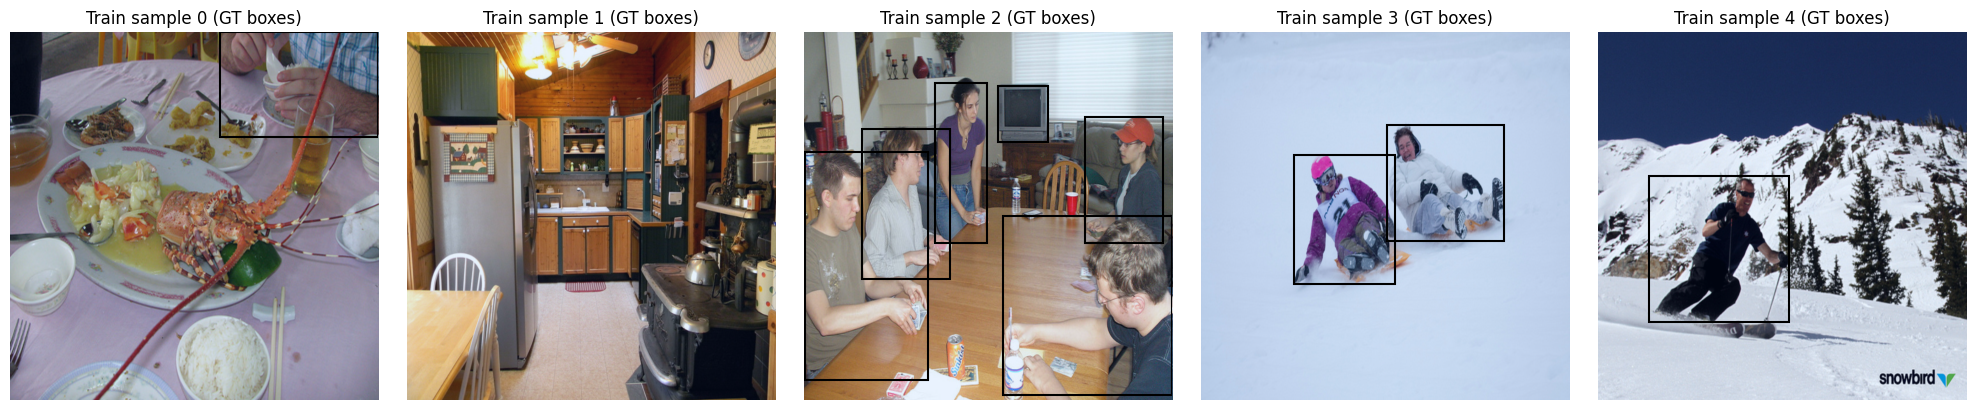

In [21]:
# Visualize 5 training images with GT boxes (from batch["targets"])

import torch
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def visualize_gt_from_batch(batch, num_images: int = 5):
    images = batch["image_nat"]          # [B, 3, H, W]
    targets = batch["targets"]           # list of length B (each a dict with "boxes")
    B = min(num_images, images.size(0))

    fig, axes = plt.subplots(1, B, figsize=(4 * B, 4))
    if B == 1:
        axes = [axes]

    for i in range(B):
        img = images[i].detach().cpu()

        # Simple per-image min-max normalization for display
        img_min, img_max = img.min(), img.max()
        img = (img - img_min) / (img_max - img_min + 1e-5)
        img_np = img.permute(1, 2, 0).numpy()  # [H, W, 3]

        ax = axes[i]
        ax.imshow(img_np)
        ax.set_title(f"Train sample {i} (GT boxes)")
        ax.axis("off")

        # GT boxes are stored as [x, y, w, h] (after resizing)
        tgt = targets[i]
        boxes_xywh = tgt["boxes"].detach().cpu()  # [N, 4]

        for box in boxes_xywh:
            x, y, w, h = box.tolist()
            rect = patches.Rectangle(
                (x, y), w, h,
                fill=False,
                linewidth=1.5,
            )
            ax.add_patch(rect)

    plt.tight_layout()
    plt.show()


# Take one batch from the training loader and visualize
batch = next(iter(train_loader))
visualize_gt_from_batch(batch, num_images=5)


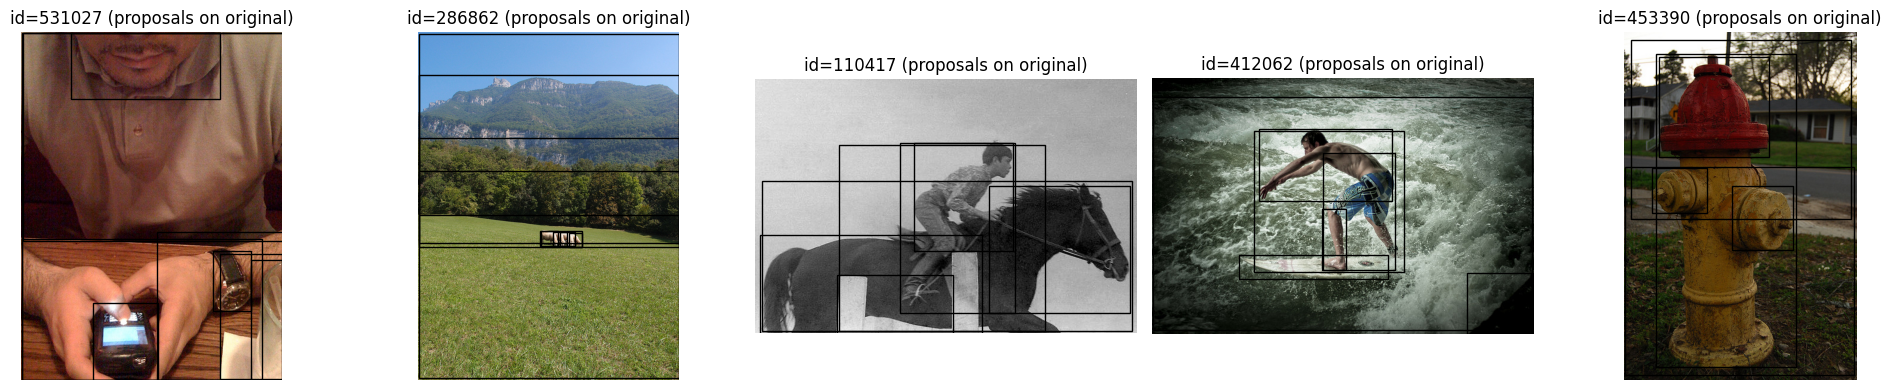

In [25]:
# Visualize 5 training images with *proposal* boxes on the ORIGINAL COCO images

import torch
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image

def visualize_proposals_on_original(
    batch,
    num_images: int = 5,
    max_props_per_img: int = 50,
):
    images_nat = batch["image_nat"]      # [B, 3, H_resized, W_resized]
    targets    = batch["targets"]        # list of length B
    proposals_batch = batch["proposals"] # list of length B

    B = min(num_images, len(targets))

    fig, axes = plt.subplots(1, B, figsize=(4 * B, 4))
    if B == 1:
        axes = [axes]

    for i in range(B):
        tgt = targets[i]
        img_id = int(tgt["image_id"].item())  # COCO image id

        # --- Load ORIGINAL COCO image (unscaled) ---
        img_info = coco_train.loadImgs([img_id])[0]
        file_name = img_info["file_name"]
        path = COCO_TRAIN_IMG_DIR / file_name
        img_orig = Image.open(path).convert("RGB")
        orig_w, orig_h = img_orig.size  # (width, height)

        ax = axes[i]
        ax.imshow(img_orig)
        ax.set_title(f"id={img_id} (proposals on original)")
        ax.axis("off")

        # --- Get proposals from the batch (these are in RESIZED coords) ---
        props_list = proposals_batch[i]

        # Handle both list-of-dicts and single-dict cases
        if isinstance(props_list, dict):
            props_entries = [props_list]
        else:
            props_entries = props_list

        if len(props_entries) == 0:
            continue

        # Take the first proposal set (as in your training code)
        prop_entry = props_entries[0]
        boxes_scaled = prop_entry["boxes"].detach().cpu()  # [K, 4] in resized coords (xyxy)
        scores = prop_entry.get("scores", None)

        # Optionally sort by score and keep top-K
        if scores is not None:
            scores = scores.detach().cpu()
            order = torch.argsort(scores, descending=True)
            boxes_scaled = boxes_scaled[order]
        boxes_scaled = boxes_scaled[:max_props_per_img]

        # --- Compute scale factors and unscale boxes back to original image space ---
        # images_nat[i] is the resized tensor for this image
        _, H_resized, W_resized = images_nat[i].shape

        # Resize transform used: (orig_w, orig_h) -> (W_resized, H_resized)
        sx = W_resized / float(orig_w)
        sy = H_resized / float(orig_h)

        boxes_orig = boxes_scaled.clone()
        boxes_orig[:, 0] = boxes_orig[:, 0] / sx  # x1
        boxes_orig[:, 1] = boxes_orig[:, 1] / sy  # y1
        boxes_orig[:, 2] = boxes_orig[:, 2] / sx  # x2
        boxes_orig[:, 3] = boxes_orig[:, 3] / sy  # y2

        # --- Draw proposals on the ORIGINAL image ---
        for box in boxes_orig:
            x1, y1, x2, y2 = box.tolist()
            w = x2 - x1
            h = y2 - y1
            rect = patches.Rectangle(
                (x1, y1),
                w,
                h,
                fill=False,
                linewidth=1.0,
            )
            ax.add_patch(rect)

    plt.tight_layout()
    plt.show()


# Take one batch and visualize
batch = next(iter(train_loader))
visualize_proposals_on_original(batch, num_images=5, max_props_per_img=50)


In [ ]:
# Quick diagnostic (no code changes needed in core):
print("Teacher AR:")
evaluate_vclr(model)  # current behavior

print("\nStudent AR (bypassing EMA):")
evaluate_vclr(model.student)

Teacher AR:
Loading and preparing results...
DONE (t=35.07s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=146.05s).
Accumulating evaluation results...
DONE (t=13.26s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.002
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.005
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.002
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.001
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.005
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.005
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.021
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.079
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= sm